In [1]:
import json
import csv
import os
import glob
import sys
import datetime
import time
import re
import ast
import itertools
import collections
import nltk
from nltk import bigrams
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, box, MultiPolygon
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

### Get tweet data and create pandas dataframe

In [2]:
date = "aug_oct22"
print (date)

aug_oct22


In [3]:
#path to directory containing tweet json files
directory = "/Users/mds228/social_sensing/fracking_tweets/filtered_tweets1"

#create pandas dataframe for tweets
df_tweets = pd.DataFrame()

#loop through each tweet file in directory, check number of tweets in each file and add to dataframe
for file in os.listdir(directory):
    filename = str(file)
    print(filename)
    with open(directory + '/' + filename) as file:
        data = json.load(file)
        print(len(data)) #to check the number of tweets in the file
    df = pd.json_normalize(data)
    if df_tweets.empty:
        df_tweets = df
    else:
        df_tweets = pd.concat([df_tweets, df])

#check number of tweets in dataframe is as expected and look at the first 5 rows
print(len(df_tweets))

#.head() returns the top 5(by default ) lines of the dataframe
df_tweets.head()

fracking_local_sep22.json
28763
fracking_local_aug22.json
6306
fracking_local_oct22.json
30942
66011


source_id   source    hazard source_date     source_timestamp  \
0  1575998120705798144  twitter  fracking    20220930  2022-09-30 23:56:47   
1  1575996307801456640  twitter  fracking    20220930  2022-09-30 23:49:35   
2  1575995531905576961  twitter  fracking    20220930  2022-09-30 23:46:30   
3  1575995126630842369  twitter  fracking    20220930  2022-09-30 23:44:53   
4  1575994656701419532  twitter  fracking    20220930  2022-09-30 23:43:01   

                                         source_text  \
0  @PaulGardinerDJ @Ed_Miliband Years of explorat...   
1  @Ed_Miliband Apparently 'local consent' will i...   
2  @tomfenn8 @tomhfh The fracking companies thems...   
3  @SimonHaydonx @ErdmuteD @SouthwoodTerry Their ...   
4  @Thewiseman1234 @EssexPR Dollar v. strong at p...   

                                         source_json  \
0  {"public_metrics": {"retweet_count": 0, "reply...   
1  {"public_metrics": {"retweet_count": 0, "reply...   
2  {"public_metrics": {"retweet_count": 0, "reply...   
3  {"entities": {"hashtags": [{"start": 145, "end...   
4  {"public_metrics": {"retweet_count": 0, "reply...   

                                         source_html  \
0  <blockquote class='missing'>This tweet is no l...   
1  <blockquote class='missing'>This tweet is no l...   
2  <blockquote class='missing'>This tweet is no l...   
3  <blockquote class='missing'>This tweet is no l...   
4  <blockquote class='missing'>This tweet is no l...   

                                            location  warning language  \
0  POLYGON ((-1.3736561781303414 53.0856924320251...        0       en   
1  POLYGON ((-1.3736561781303414 53.0856924320251...        0       en   
2  POLYGON ((-0.3838 51.246520000000004, -0.3838 ...        0       en   
3  MULTIPOLYGON (((-2.759343912461919 51.57778765...        0       en   
4  POLYGON ((-3.0481956302092037 53.8731991926882...        0       en   

   possibly_sensitive  
0               False  
1               False  
2               False  
3               False  
4               False

#### Calculate sentiment of tweet text and add to dataframe

In [4]:
df_tweets['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df_tweets['source_text']]
df_tweets['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df_tweets['source_text']]
df_tweets['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df_tweets['source_text']]
df_tweets['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df_tweets['source_text']]
df_tweets.head()

source_id   source    hazard source_date     source_timestamp  \
0  1575998120705798144  twitter  fracking    20220930  2022-09-30 23:56:47   
1  1575996307801456640  twitter  fracking    20220930  2022-09-30 23:49:35   
2  1575995531905576961  twitter  fracking    20220930  2022-09-30 23:46:30   
3  1575995126630842369  twitter  fracking    20220930  2022-09-30 23:44:53   
4  1575994656701419532  twitter  fracking    20220930  2022-09-30 23:43:01   

                                         source_text  \
0  @PaulGardinerDJ @Ed_Miliband Years of explorat...   
1  @Ed_Miliband Apparently 'local consent' will i...   
2  @tomfenn8 @tomhfh The fracking companies thems...   
3  @SimonHaydonx @ErdmuteD @SouthwoodTerry Their ...   
4  @Thewiseman1234 @EssexPR Dollar v. strong at p...   

                                         source_json  \
0  {"public_metrics": {"retweet_count": 0, "reply...   
1  {"public_metrics": {"retweet_count": 0, "reply...   
2  {"public_metrics": {"retweet_count": 0, "reply...   
3  {"entities": {"hashtags": [{"start": 145, "end...   
4  {"public_metrics": {"retweet_count": 0, "reply...   

                                         source_html  \
0  <blockquote class='missing'>This tweet is no l...   
1  <blockquote class='missing'>This tweet is no l...   
2  <blockquote class='missing'>This tweet is no l...   
3  <blockquote class='missing'>This tweet is no l...   
4  <blockquote class='missing'>This tweet is no l...   

                                            location  warning language  \
0  POLYGON ((-1.3736561781303414 53.0856924320251...        0       en   
1  POLYGON ((-1.3736561781303414 53.0856924320251...        0       en   
2  POLYGON ((-0.3838 51.246520000000004, -0.3838 ...        0       en   
3  MULTIPOLYGON (((-2.759343912461919 51.57778765...        0       en   
4  POLYGON ((-3.0481956302092037 53.8731991926882...        0       en   

   possibly_sensitive  compound    neg    neu    pos  
0               False   -0.1263  0.053  0.905  0.042  
1               False    0.5848  0.041  0.804  0.155  
2               False   -0.3400  0.050  0.950  0.000  
3               False    0.6239  0.043  0.768  0.189  
4               False    0.6872  0.000  0.788  0.212

### Use pandas for some initial analysis of the dataset

In [5]:
print(df_tweets['source_id'].count())

66011


In [6]:
# check for any duplicate tweets in dataset and remove them
df_tweets.drop_duplicates(subset=None, inplace=True)
print(df_tweets['source_id'].count())

66011


In [7]:
# convert 'source_timestamp' values to datetime format
df_tweets['source_timestamp'] = pd.to_datetime(df_tweets['source_timestamp'], format='%Y-%m-%d %H:%M:%S')
# sort dataset by date/time
df_tweets = df_tweets.sort_values(by='source_timestamp')
print(df_tweets.head())

                source_id   source    hazard source_date    source_timestamp  \
6305  1553901074674634752  twitter  fracking    20220801 2022-08-01 00:31:00   
6304  1553922750292676608  twitter  fracking    20220801 2022-08-01 01:57:08   
6303  1553925072637001729  twitter  fracking    20220801 2022-08-01 02:06:22   
6302  1553983901617782785  twitter  fracking    20220801 2022-08-01 06:00:08   
6301  1554000651948015617  twitter  fracking    20220801 2022-08-01 07:06:42   

                                            source_text  \
6305  @DefiantLs NO HE JUST STOPS FRACKING, FURTHER ...   
6304  SKy is owned by Murdoch (fox) he's utterly cor...   
6303  Petition: End the ban on fracking https://t.co...   
6302  @Kate3015 Labor voted with the LNP over 130 ti...   
6301  @drjanaway You won’t get in next time matey.  ...   

                                            source_json  \
6305  {"author_id": "1520643265480957953", "lang": "...   
6304  {"author_id": "1193008291586232320", "ed

#### Plot a timeseries

In [8]:
# prepare data to plot tweet count and sentiment by hour
tweet_counts_h = df_tweets.resample('H', on='source_timestamp').source_id.count()
sentiment_mean_h = df_tweets.resample('H', on='source_timestamp').compound.mean()

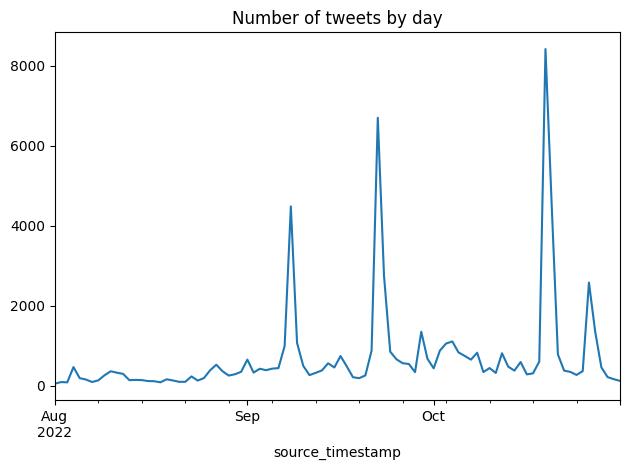

In [85]:
# plot tweet count timeseries by hour
plt.figure()
tweet_counts_d.plot(kind="line", fontsize=10)
plt.title("Number of tweets by day")
plt.tight_layout()
plt.show()

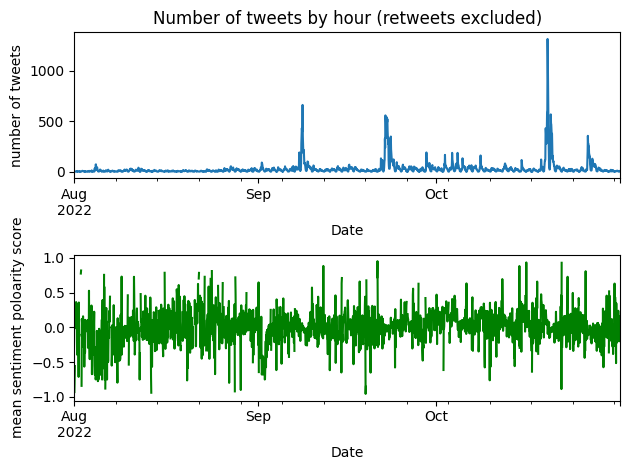

In [9]:
# plot tweet count timeseries by hour
plt.subplot(2,1,1)
tweet_counts_h.plot(kind="line", fontsize=10, xlabel='Date', ylabel='number of tweets')
plt.title("Number of tweets by hour (retweets excluded)")

# plot tweet sentiment timeseries by hour
plt.subplot(2,1,2)
sentiment_mean_h.plot(kind="line", fontsize=10, xlabel='Date', ylabel='mean sentiment poloarity score', color="green")

plt.tight_layout()
plt.show()

In [10]:
# Hourly plot is a bit messy, resample the dataframe to plot tweets by day instead
tweet_counts_d = df_tweets.resample('D', on='source_timestamp').source_id.count()
sentiment_mean_d = df_tweets.resample('D', on='source_timestamp').compound.mean()

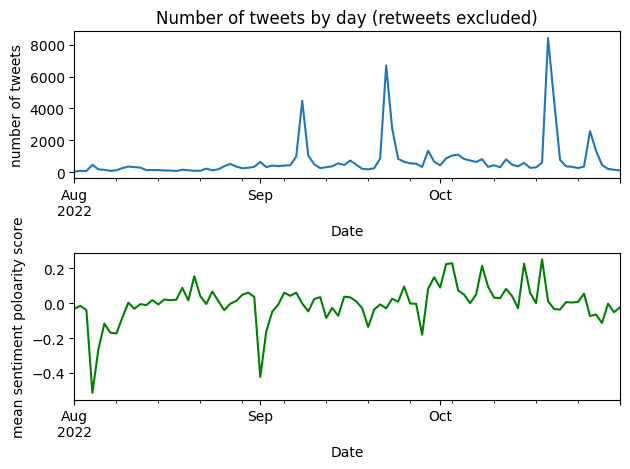

In [11]:
plt.subplot(2,1,1)
tweet_counts_d.plot(kind="line", fontsize=10, xlabel='Date', ylabel='number of tweets')
plt.title("Number of tweets by day (retweets excluded)")

plt.subplot(2,1,2)
sentiment_mean_d.plot(kind="line", fontsize=10, xlabel='Date', ylabel='mean sentiment poloarity score', color="green")

plt.tight_layout()
plt.show()

### Now use Geopandas to plot the data on a map

#### First you need to use location data for tweet to create geodataframe ready for mapping with GeoPandas

In [12]:
gdf = gpd.GeoDataFrame(df_tweets, crs=4326, geometry=gpd.GeoSeries.from_wkt(df_tweets.location))
gdf.head()

source_id   source    hazard source_date    source_timestamp  \
6305  1553901074674634752  twitter  fracking    20220801 2022-08-01 00:31:00   
6304  1553922750292676608  twitter  fracking    20220801 2022-08-01 01:57:08   
6303  1553925072637001729  twitter  fracking    20220801 2022-08-01 02:06:22   
6302  1553983901617782785  twitter  fracking    20220801 2022-08-01 06:00:08   
6301  1554000651948015617  twitter  fracking    20220801 2022-08-01 07:06:42   

                                            source_text  \
6305  @DefiantLs NO HE JUST STOPS FRACKING, FURTHER ...   
6304  SKy is owned by Murdoch (fox) he's utterly cor...   
6303  Petition: End the ban on fracking https://t.co...   
6302  @Kate3015 Labor voted with the LNP over 130 ti...   
6301  @drjanaway You won’t get in next time matey.  ...   

                                            source_json  \
6305  {"author_id": "1520643265480957953", "lang": "...   
6304  {"author_id": "1193008291586232320", "edit_his...   
6303  {"lang": "en", "edit_history_tweet_ids": ["155...   
6302  {"source": "Twitter Web App", "public_metrics"...   
6301  {"source": "Twitter for iPad", "public_metrics...   

                                            source_html  \
6305  <blockquote class='missing'>This tweet is no l...   
6304  <blockquote class='missing'>This tweet is no l...   
6303  <blockquote class='missing'>This tweet is no l...   
6302  <blockquote class='missing'>This tweet is no l...   
6301  <blockquote class='missing'>This tweet is no l...   

                                               location  warning language  \
6305  POLYGON ((-2.2874299999999996 53.43095, -2.287...        0       en   
6304  POLYGON ((-1.308003 53.490755, -1.308003 53.50...        0       en   
6303  POLYGON ((0.2977764737227441 51.47218218491557...        0       en   
6302  POLYGON ((-0.6818138096279485 54.5194319025686...        0       en   
6301  MULTIPOLYGON (((0.213795726659258 52.827118097...        0       en   

      possibly_sensitive  compound    neg    neu    pos  \
6305               False   -0.9317  0.286  0.658  0.056   
6304               False   -0.7553  0.275  0.725  0.000   
6303               False   -0.5574  0.375  0.625  0.000   
6302               False    0.0000  0.000  1.000  0.000   
6301               False    0.6712  0.084  0.734  0.182   

                                               geometry  
6305  POLYGON ((-2.28743 53.43095, -2.28743 53.53095...  
6304  POLYGON ((-1.30800 53.49076, -1.30800 53.50416...  
6303  POLYGON ((0.29778 51.47218, 0.28137 51.46140, ...  
6302  POLYGON ((-0.68181 54.51943, -0.67026 54.50074...  
6301  MULTIPOLYGON (((0.21380 52.82712, 0.20578 52.7...

## Tweets by world country

#### Need to get Countries_WGS84.shp file
#### Use GeoPandas to read shape data into a new geodataframe

In [13]:
countries = "/Users/mds228/social_sensing/mapping/Countries_WGS84/Countries_WGS84.shp"
map_countries = gpd.read_file(countries)
map_countries.head()

OBJECTID           CNTRY_NAME  \
0         1                Aruba   
1         2  Antigua and Barbuda   
2         3          Afghanistan   
3         4              Algeria   
4         5           Azerbaijan   

                                            geometry  
0  POLYGON ((-69.88223 12.41111, -69.94695 12.436...  
1  MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ...  
2  POLYGON ((61.27656 35.60725, 61.29638 35.62853...  
3  POLYGON ((-5.15213 30.18047, -5.13917 30.19236...  
4  MULTIPOLYGON (((45.02583 41.03055, 45.00999 41...

#### Now let's merge our tweet geodataframe and our countries geodataframe using 'sjoin' - this will allow us to assign tweet location to a country polygon from the shapefile data

In [14]:
gdf_countries = gdf.to_crs(epsg=4326) # this transforms the geometry to the correct coordinate reference system for the shapefile.
tweets_countries =gpd.sjoin(gdf_countries, map_countries, how="inner", predicate='intersects')
tweets_countries.head()

source_id   source    hazard source_date    source_timestamp  \
6305  1553901074674634752  twitter  fracking    20220801 2022-08-01 00:31:00   
6304  1553922750292676608  twitter  fracking    20220801 2022-08-01 01:57:08   
6303  1553925072637001729  twitter  fracking    20220801 2022-08-01 02:06:22   
6302  1553983901617782785  twitter  fracking    20220801 2022-08-01 06:00:08   
6301  1554000651948015617  twitter  fracking    20220801 2022-08-01 07:06:42   

                                            source_text  \
6305  @DefiantLs NO HE JUST STOPS FRACKING, FURTHER ...   
6304  SKy is owned by Murdoch (fox) he's utterly cor...   
6303  Petition: End the ban on fracking https://t.co...   
6302  @Kate3015 Labor voted with the LNP over 130 ti...   
6301  @drjanaway You won’t get in next time matey.  ...   

                                            source_json  \
6305  {"author_id": "1520643265480957953", "lang": "...   
6304  {"author_id": "1193008291586232320", "edit_his...   
6303  {"lang": "en", "edit_history_tweet_ids": ["155...   
6302  {"source": "Twitter Web App", "public_metrics"...   
6301  {"source": "Twitter for iPad", "public_metrics...   

                                            source_html  \
6305  <blockquote class='missing'>This tweet is no l...   
6304  <blockquote class='missing'>This tweet is no l...   
6303  <blockquote class='missing'>This tweet is no l...   
6302  <blockquote class='missing'>This tweet is no l...   
6301  <blockquote class='missing'>This tweet is no l...   

                                               location  warning language  \
6305  POLYGON ((-2.2874299999999996 53.43095, -2.287...        0       en   
6304  POLYGON ((-1.308003 53.490755, -1.308003 53.50...        0       en   
6303  POLYGON ((0.2977764737227441 51.47218218491557...        0       en   
6302  POLYGON ((-0.6818138096279485 54.5194319025686...        0       en   
6301  MULTIPOLYGON (((0.213795726659258 52.827118097...        0       en   

      possibly_sensitive  compound    neg    neu    pos  \
6305               False   -0.9317  0.286  0.658  0.056   
6304               False   -0.7553  0.275  0.725  0.000   
6303               False   -0.5574  0.375  0.625  0.000   
6302               False    0.0000  0.000  1.000  0.000   
6301               False    0.6712  0.084  0.734  0.182   

                                               geometry  index_right  \
6305  POLYGON ((-2.28743 53.43095, -2.28743 53.53095...          230   
6304  POLYGON ((-1.30800 53.49076, -1.30800 53.50416...          230   
6303  POLYGON ((0.29778 51.47218, 0.28137 51.46140, ...          230   
6302  POLYGON ((-0.68181 54.51943, -0.67026 54.50074...          230   
6301  MULTIPOLYGON (((0.21380 52.82712, 0.20578 52.7...          230   

      OBJECTID      CNTRY_NAME  
6305       231  United Kingdom  
6304       231  United Kingdom  
6303       231  United Kingdom  
6302       231  United Kingdom  
6301       231  United Kingdom

##### OPTIONAL: Send data to a csv file for checking/further analysis

In [15]:
outfile = "/Users/mds228/social_sensing/fracking_tweets/fracking_local_" + date + ".csv"
tweets_countries.to_csv(outfile)

#### List the number of tweets (tweet count) by country - check if this looks sensible

In [16]:
tweets_by_country = tweets_countries.groupby( [ "CNTRY_NAME"] ).size().to_frame(name = 'count').reset_index()
tweets_by_country

CNTRY_NAME  count
0         Ireland    947
1  United Kingdom  65455

#### Merge the geodataframe with the cleaned up csv dataframe using country name column heading

In [17]:
# joining the geodataframe with the cleaned up csv dataframe
merged = map_countries.set_index('CNTRY_NAME').join(tweets_by_country.set_index('CNTRY_NAME'))
# update any NaN values in the count column to 0
merged["count"] = merged["count"].fillna(0)
#.head() returns the top 5(by default ) lines of the dataframe
merged.max(numeric_only=True)

OBJECTID      251.0
count       65455.0
dtype: float64

In [18]:
merged.head()

OBJECTID  \
CNTRY_NAME                      
Aruba                       1   
Antigua and Barbuda         2   
Afghanistan                 3   
Algeria                     4   
Azerbaijan                  5   

                                                              geometry  count  
CNTRY_NAME                                                                     
Aruba                POLYGON ((-69.88223 12.41111, -69.94695 12.436...    0.0  
Antigua and Barbuda  MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ...    0.0  
Afghanistan          POLYGON ((61.27656 35.60725, 61.29638 35.62853...    0.0  
Algeria              POLYGON ((-5.15213 30.18047, -5.13917 30.19236...    0.0  
Azerbaijan           MULTIPOLYGON (((45.02583 41.03055, 45.00999 41...    0.0

### Now let's make a map!

#### Plotting tweet count for each country polygon

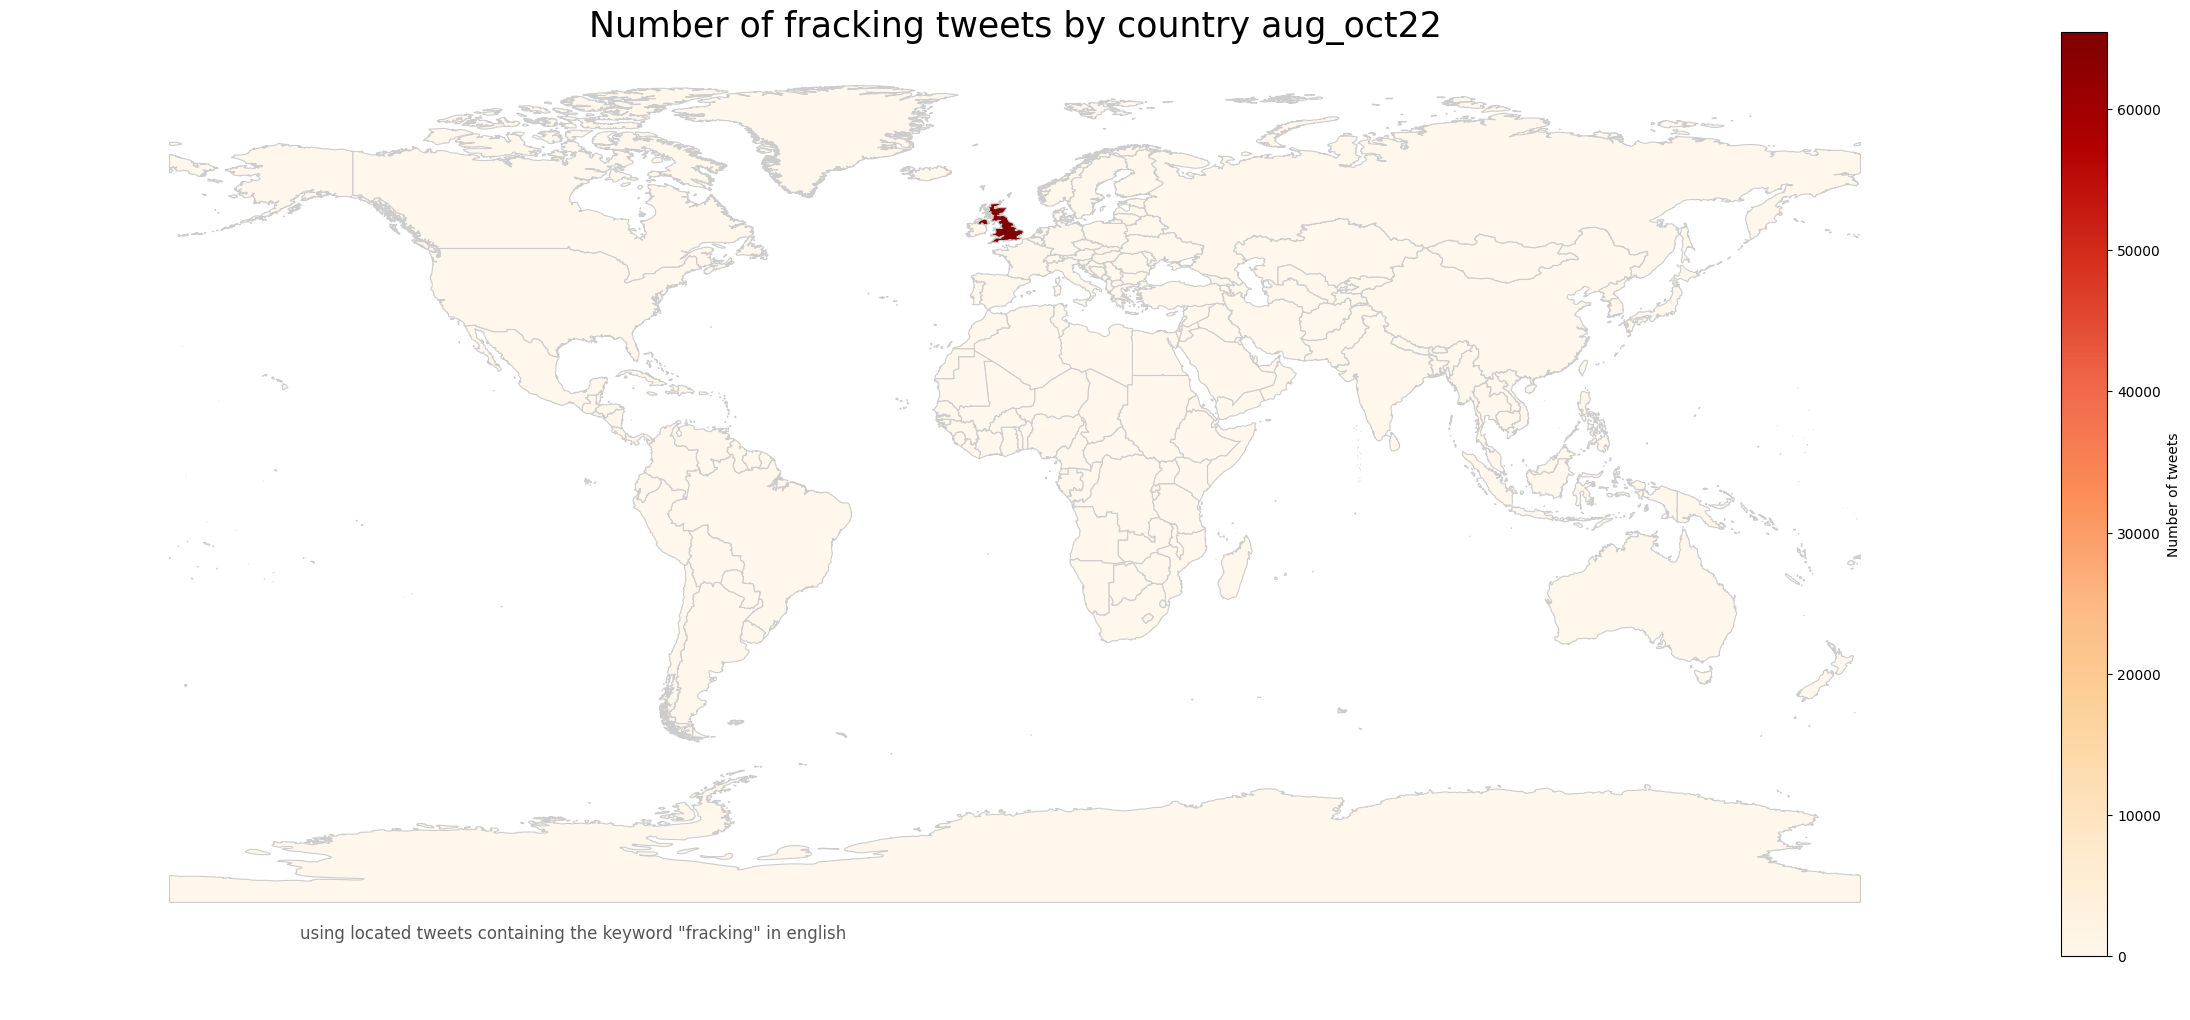

In [19]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'count'
# set the range for the choropleth
vmin, vmax = merged['count'].min(), merged['count'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

merged.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
title = 'Number of fracking tweets by country ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('using located tweets containing the keyword "fracking" in english',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Number of tweets', format='%1.0f', ax=ax)
#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_country_english_' + date + '.png'
# fig.savefig(fig_name, dpi=300)

## Your turn!!

### Plot tweet text sentiment instead of tweet count - using the same steps as above for tweet count map

In [20]:
#use the tweet dataframe to group the compound sentiment of tweets by country
tweetsent_by_country = tweets_countries.groupby("CNTRY_NAME")['compound'].mean().reset_index()
tweetsent_by_country.head()

CNTRY_NAME  compound
0         Ireland -0.041337
1  United Kingdom  0.004196

In [21]:
# join the geodataframe with the cleaned up csv dataframe
mergedsent = map_countries.set_index('CNTRY_NAME').join(tweetsent_by_country.set_index('CNTRY_NAME'))
# update any NaN values in the count column to 0
#mergedsent["compound"] = mergedsent["compound"].fillna(0)
#.head() returns the top 5(by default ) lines of the dataframe
mergedsent.head()

OBJECTID  \
CNTRY_NAME                      
Aruba                       1   
Antigua and Barbuda         2   
Afghanistan                 3   
Algeria                     4   
Azerbaijan                  5   

                                                              geometry  \
CNTRY_NAME                                                               
Aruba                POLYGON ((-69.88223 12.41111, -69.94695 12.436...   
Antigua and Barbuda  MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ...   
Afghanistan          POLYGON ((61.27656 35.60725, 61.29638 35.62853...   
Algeria              POLYGON ((-5.15213 30.18047, -5.13917 30.19236...   
Azerbaijan           MULTIPOLYGON (((45.02583 41.03055, 45.00999 41...   

                     compound  
CNTRY_NAME                     
Aruba                     NaN  
Antigua and Barbuda       NaN  
Afghanistan               NaN  
Algeria                   NaN  
Azerbaijan                NaN

In [22]:
mergedsent.max(numeric_only=True)

OBJECTID    251.000000
compound      0.004196
dtype: float64

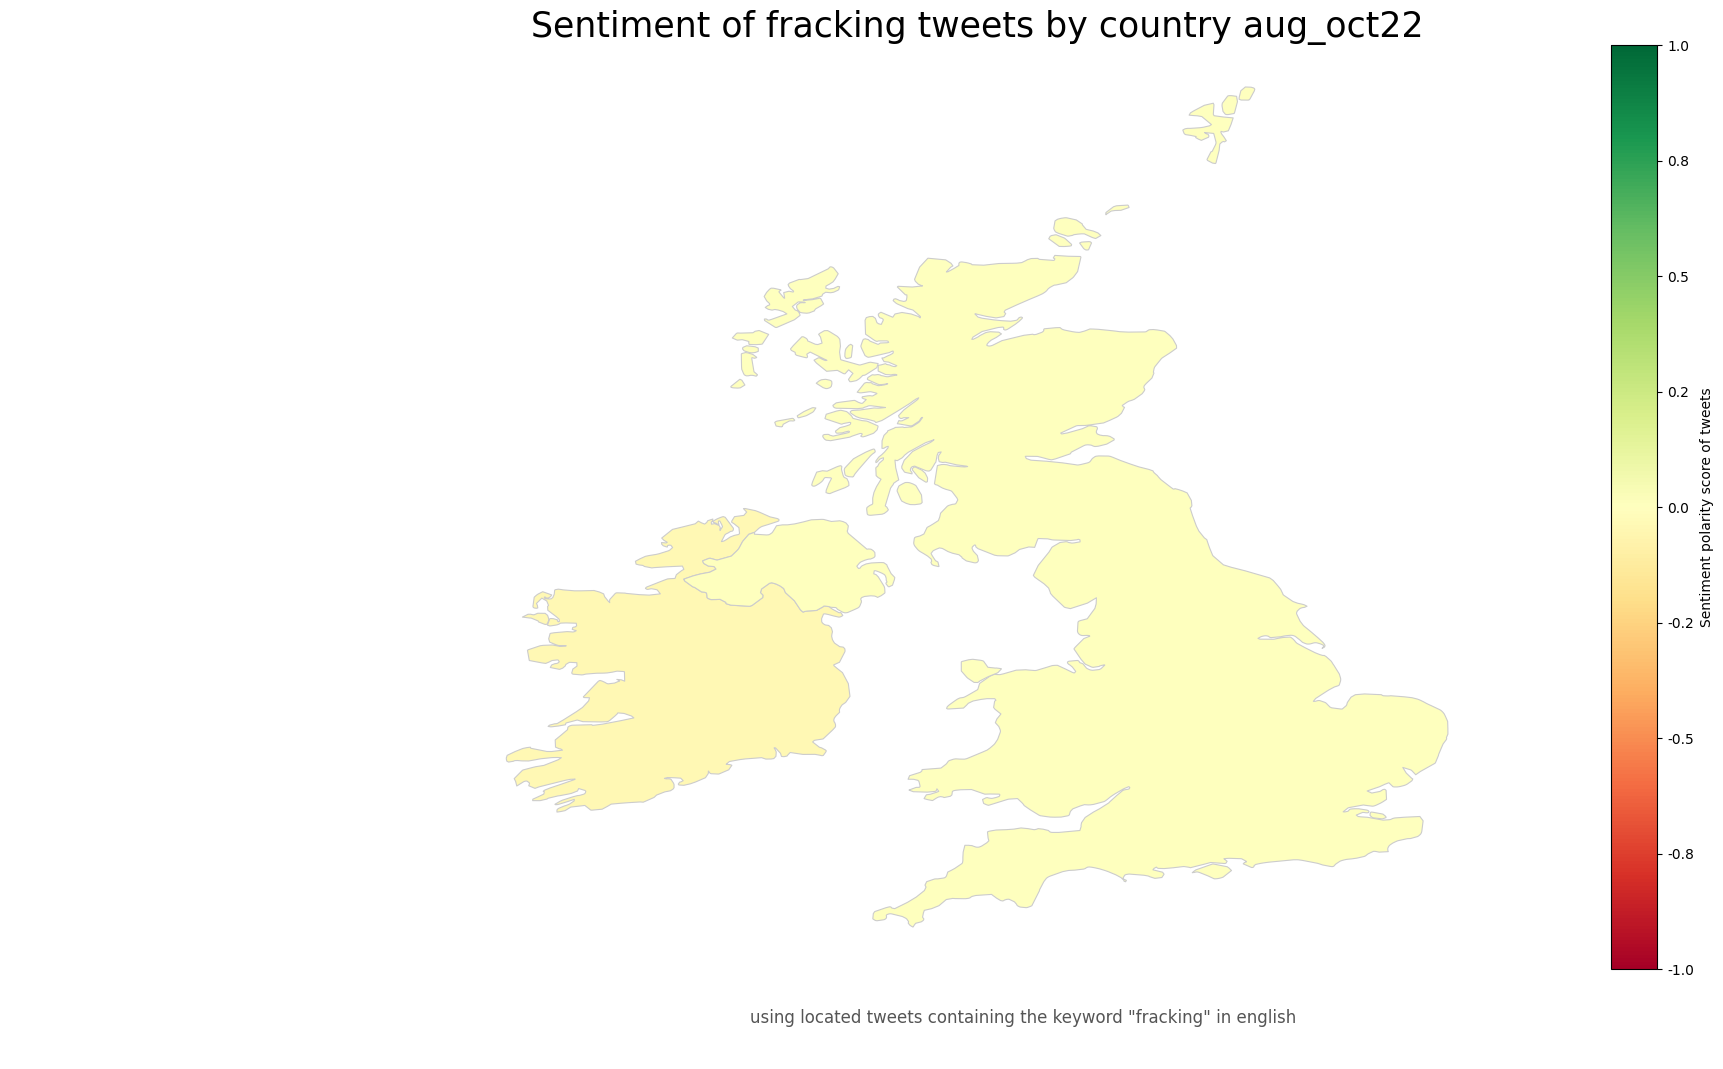

In [23]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'compound'

# set the range for the choropleth
vmin, vmax = -1, 1

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

mergedsent.plot(column=variable, cmap='RdYlGn', linewidth=0.8, ax=ax, vmin=vmin, vmax=vmax, edgecolor='0.8')

# remove the axis
ax.axis('off')

# add a title
title = 'Sentiment of fracking tweets by country ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})

# create an annotation for the data source
ax.annotate('using located tweets containing the keyword "fracking" in english',xy=(0.25, .05), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Sentiment polarity score of tweets', format='%0.1f', ax=ax)

#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_sentiment_country_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

### Plot Tweet count/sentiment by European country admin level 1 using the same steps as above for country

In [24]:
# You will need the "ref-nuts-2016-3035_LEVL_1" shapefile. Read the shapefile using Geopandas.
europe = "/Users/mds228/social_sensing/mapping/ref-nuts-2016-01m.shp/NUTS_RG_01M_2016_3035_LEVL_1.shp/NUTS_RG_01M_2016_3035_LEVL_1.shp"
map_europe = gpd.read_file(europe)
map_europe.head()

LEVL_CODE NUTS_ID CNTR_CODE                NAME_LATN  \
0          1     BE3        BE          RÉGION WALLONNE   
1          1     CH0        CH  SCHWEIZ/SUISSE/SVIZZERA   
2          1     DE1        DE        BADEN-WÜRTTEMBERG   
3          1     CY0        CY                   Kypros   
4          1     DEA        DE      NORDRHEIN-WESTFALEN   

                 NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE  FID  \
0          RÉGION WALLONNE           0          0           0  BE3   
1  SCHWEIZ/SUISSE/SVIZZERA           0          0           0  CH0   
2        BADEN-WÜRTTEMBERG           0          0           0  DE1   
3                   ΚΥΠΡΟΣ           0          0           0  CY0   
4      NORDRHEIN-WESTFALEN           0          0           0  DEA   

                                            geometry  
0  MULTIPOLYGON (((4016501.803 3080744.573, 40170...  
1  POLYGON ((4217105.160 2744025.879, 4217668.743...  
2  MULTIPOLYGON (((4327060.365 2936754.230, 43273...  
3  MULTIPOLYGON (((6527040.718 1762367.593, 65267...  
4  POLYGON ((4232925.634 3266469.257, 4232630.154...

In [25]:
# use sjoin to merge the map data with the located tweet data
# you may need to transform the Geodataframe to a different coordinate reference system (crs)
# https://geopandas.org/en/stable/docs/user_guide/projections.html
# https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html

gdf_europe = gdf.to_crs(epsg=3035)
tweets_europe = gpd.sjoin(gdf_europe, map_europe, how="inner", predicate='intersects')
tweets_europe.head()

source_id   source    hazard source_date    source_timestamp  \
6305  1553901074674634752  twitter  fracking    20220801 2022-08-01 00:31:00   
6286  1554080594598002688  twitter  fracking    20220801 2022-08-01 12:24:21   
6283  1554092244529020930  twitter  fracking    20220801 2022-08-01 13:10:39   
6282  1554092399781187584  twitter  fracking    20220801 2022-08-01 13:11:16   
6277  1554100952193552385  twitter  fracking    20220801 2022-08-01 13:45:15   

                                            source_text  \
6305  @DefiantLs NO HE JUST STOPS FRACKING, FURTHER ...   
6286  Guest post: Yorkshire Landowners question Cons...   
6283  Guest post: Yorkshire Landowners question Cons...   
6282  @FrackFreeDee If we lose the farmland for food...   
6277  Guest post: Yorkshire Landowners question Cons...   

                                            source_json  \
6305  {"author_id": "1520643265480957953", "lang": "...   
6286  {"text": "Guest post: Yorkshire Landowners que...   
6283  {"text": "Guest post: Yorkshire Landowners que...   
6282  {"text": "@FrackFreeDee If we lose the farmlan...   
6277  {"author_id": "36360938", "id": "1554100952193...   

                                            source_html  \
6305  <blockquote class='missing'>This tweet is no l...   
6286  <blockquote class='missing'>This tweet is no l...   
6283  <blockquote class='missing'>This tweet is no l...   
6282  <blockquote class='missing'>This tweet is no l...   
6277  <blockquote class='missing'>This tweet is no l...   

                                               location  warning  ...  \
6305  POLYGON ((-2.2874299999999996 53.43095, -2.287...        0  ...   
6286  MULTIPOLYGON (((-0.9638144970198903 54.5857372...        0  ...   
6283  MULTIPOLYGON (((-0.960272280144296 54.58501750...        0  ...   
6282  MULTIPOLYGON (((-3.1037330027778753 53.3000135...        0  ...   
6277  MULTIPOLYGON (((-0.960272280144296 54.58501750...        0  ...   

     index_right  LEVL_CODE  NUTS_ID  CNTR_CODE             NAME_LATN  \
6305          90          1      UKD         UK  NORTH WEST (ENGLAND)   
6286          90          1      UKD         UK  NORTH WEST (ENGLAND)   
6283          90          1      UKD         UK  NORTH WEST (ENGLAND)   
6282          90          1      UKD         UK  NORTH WEST (ENGLAND)   
6277          90          1      UKD         UK  NORTH WEST (ENGLAND)   

                 NUTS_NAME MOUNT_TYPE  URBN_TYPE  COAST_TYPE  FID  
6305  NORTH WEST (ENGLAND)          0          0           0  UKD  
6286  NORTH WEST (ENGLAND)          0          0           0  UKD  
6283  NORTH WEST (ENGLAND)          0          0           0  UKD  
6282  NORTH WEST (ENGLAND)          0          0           0  UKD  
6277  NORTH WEST (ENGLAND)          0          0           0  UKD  

[5 rows x 27 columns]

In [26]:
#outfile = "[path to outfile]_tweets_europe.csv"
#tweets_europe.to_csv(outfile)

#### Plot tweet count by admin area

In [27]:
#group tweet counts by NUTS_NAME
tweets_europe_by_country = tweets_europe.groupby( [ "NUTS_NAME"] ).size().to_frame(name = 'count').reset_index()
tweets_europe_by_country

NUTS_NAME  count
0    EAST MIDLANDS (ENGLAND)   9556
1            EAST OF ENGLAND  17887
2                    IRELAND    946
3                     LONDON  16090
4       NORTH EAST (ENGLAND)   5285
5       NORTH WEST (ENGLAND)  17036
6           NORTHERN IRELAND    791
7                   SCOTLAND   5724
8       SOUTH EAST (ENGLAND)  23453
9       SOUTH WEST (ENGLAND)  10160
10                     WALES   5195
11   WEST MIDLANDS (ENGLAND)   8745
12  YORKSHIRE AND THE HUMBER  11414

In [28]:
# join the geodataframe with the cleaned up csv dataframe
merged_europe = map_europe.set_index('NUTS_NAME').join(tweets_europe_by_country.set_index('NUTS_NAME'))
# update any NaN values in the count column to 0 (optional)
merged_europe["count"] = merged_europe["count"].fillna(0)
merged_europe.head()

LEVL_CODE NUTS_ID CNTR_CODE                NAME_LATN  \
NUTS_NAME                                                                       
RÉGION WALLONNE                  1     BE3        BE          RÉGION WALLONNE   
SCHWEIZ/SUISSE/SVIZZERA          1     CH0        CH  SCHWEIZ/SUISSE/SVIZZERA   
BADEN-WÜRTTEMBERG                1     DE1        DE        BADEN-WÜRTTEMBERG   
ΚΥΠΡΟΣ                           1     CY0        CY                   Kypros   
NORDRHEIN-WESTFALEN              1     DEA        DE      NORDRHEIN-WESTFALEN   

                         MOUNT_TYPE  URBN_TYPE  COAST_TYPE  FID  \
NUTS_NAME                                                         
RÉGION WALLONNE                   0          0           0  BE3   
SCHWEIZ/SUISSE/SVIZZERA           0          0           0  CH0   
BADEN-WÜRTTEMBERG                 0          0           0  DE1   
ΚΥΠΡΟΣ                            0          0           0  CY0   
NORDRHEIN-WESTFALEN               0          0           0  DEA   

                                                                  geometry  \
NUTS_NAME                                                                    
RÉGION WALLONNE          MULTIPOLYGON (((4016501.803 3080744.573, 40170...   
SCHWEIZ/SUISSE/SVIZZERA  POLYGON ((4217105.160 2744025.879, 4217668.743...   
BADEN-WÜRTTEMBERG        MULTIPOLYGON (((4327060.365 2936754.230, 43273...   
ΚΥΠΡΟΣ                   MULTIPOLYGON (((6527040.718 1762367.593, 65267...   
NORDRHEIN-WESTFALEN      POLYGON ((4232925.634 3266469.257, 4232630.154...   

                         count  
NUTS_NAME                       
RÉGION WALLONNE            0.0  
SCHWEIZ/SUISSE/SVIZZERA    0.0  
BADEN-WÜRTTEMBERG          0.0  
ΚΥΠΡΟΣ                     0.0  
NORDRHEIN-WESTFALEN        0.0

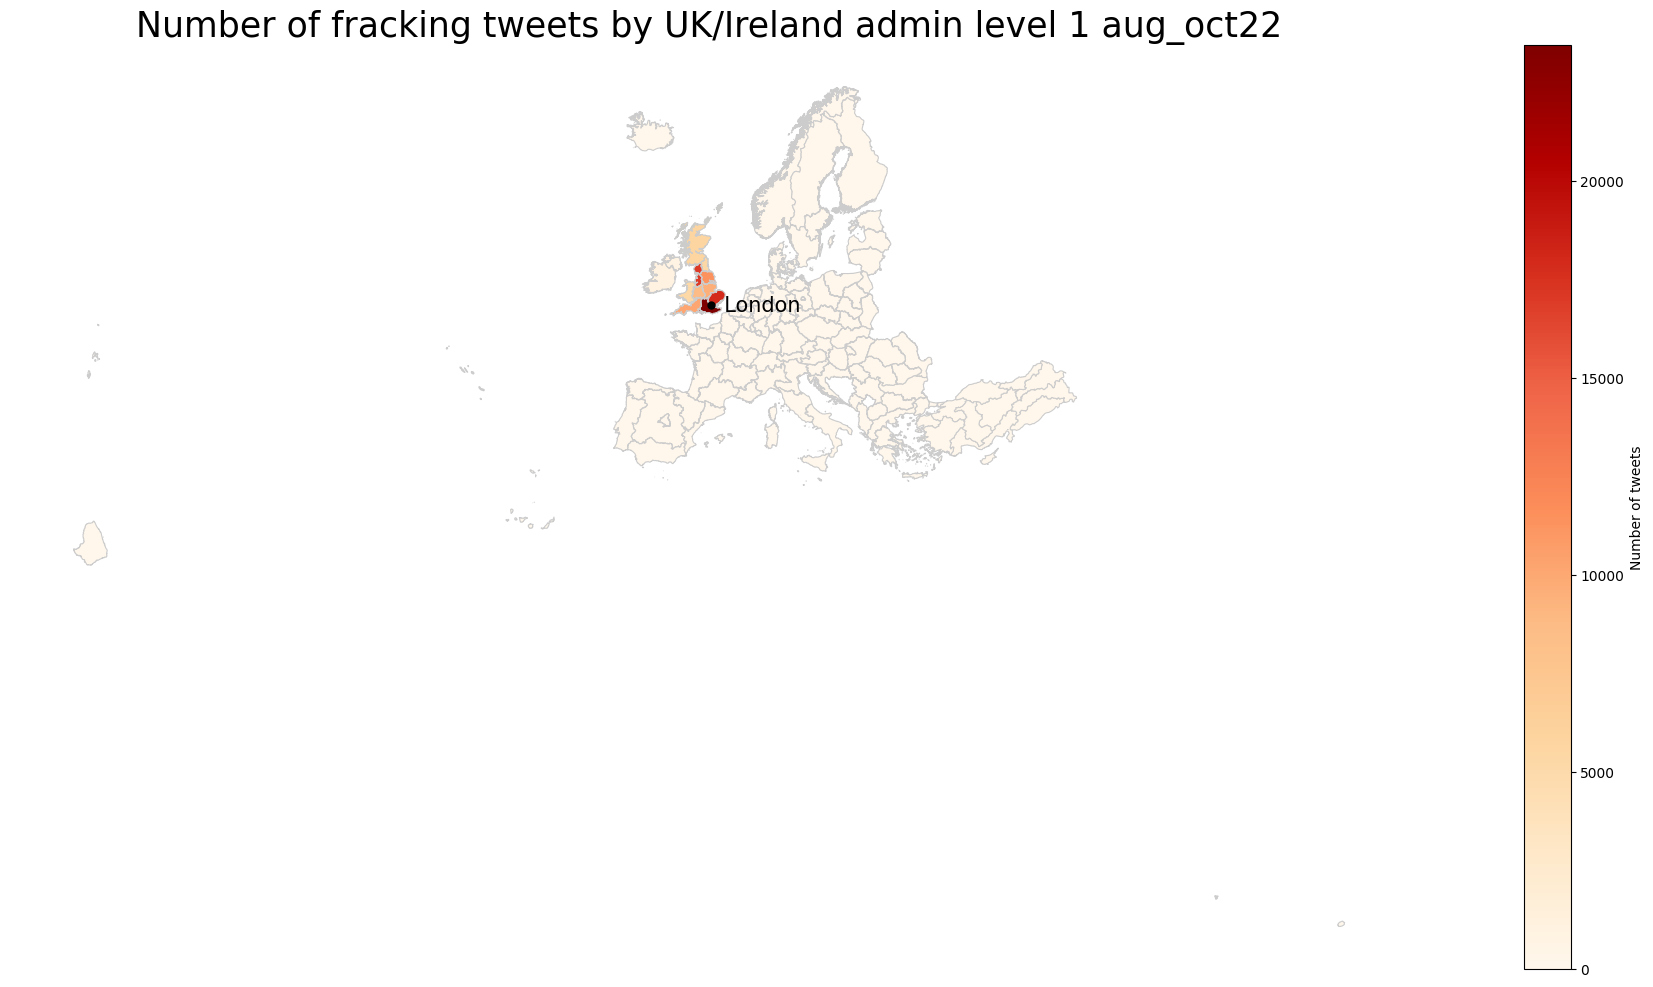

In [29]:
# Make a map of tweet count by European country admin level 1!

# set a variable that will call whatever column we want to visualise on the map
variable = 'count'

# set the range for the choropleth
vmin, vmax = merged_europe['count'].min(), merged_europe['count'].max()

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

merged_europe.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.plot(3621142.41, 3204082.16, markersize=5, marker='o', color='black')       ##transform long and lat co-ordinates to EPSG 3035 using https://epsg.io/transform
ax.text(3621142.41, 3204082.16, '  London', color='black', size=15, ha='left', va='center')

# remove the axis
ax.axis('off')

# add a title
title = 'Number of fracking tweets by UK/Ireland admin level 1 ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})

# create an annotation for the data source
#ax.annotate('using located tweets containing the keyword "fracking" in english',xy=(0.02, .02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Number of tweets', format='%1.0f', ax=ax)

#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_europe_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

#### Now plot sentiment by admin area

In [30]:
#group tweet sentiment columns ('compound', 'neg' and 'pos') by NUTS_NAME
tweetsent_europe = tweets_europe.groupby("NUTS_NAME")['compound','neg','pos'].mean().reset_index()
tweetsent_europe.head()

/var/folders/sv/cwyt9nq1123g9h8k8t5gtdg00000gp/T/ipykernel_95289/3387569085.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tweetsent_europe = tweets_europe.groupby("NUTS_NAME")['compound','neg','pos'].mean().reset_index()


NUTS_NAME  compound       neg       pos
0  EAST MIDLANDS (ENGLAND)  0.017328  0.088788  0.094825
1          EAST OF ENGLAND -0.004483  0.095500  0.095951
2                  IRELAND -0.041522  0.105492  0.091355
3                   LONDON  0.000751  0.094413  0.096256
4     NORTH EAST (ENGLAND) -0.007332  0.092463  0.093131

In [31]:
# joining the geodataframe with the cleaned up csv dataframe
mergedsent_europe = map_europe.set_index('NUTS_NAME').join(tweetsent_europe.set_index('NUTS_NAME'))
mergedsent_europe.head()

LEVL_CODE NUTS_ID CNTR_CODE                NAME_LATN  \
NUTS_NAME                                                                       
RÉGION WALLONNE                  1     BE3        BE          RÉGION WALLONNE   
SCHWEIZ/SUISSE/SVIZZERA          1     CH0        CH  SCHWEIZ/SUISSE/SVIZZERA   
BADEN-WÜRTTEMBERG                1     DE1        DE        BADEN-WÜRTTEMBERG   
ΚΥΠΡΟΣ                           1     CY0        CY                   Kypros   
NORDRHEIN-WESTFALEN              1     DEA        DE      NORDRHEIN-WESTFALEN   

                         MOUNT_TYPE  URBN_TYPE  COAST_TYPE  FID  \
NUTS_NAME                                                         
RÉGION WALLONNE                   0          0           0  BE3   
SCHWEIZ/SUISSE/SVIZZERA           0          0           0  CH0   
BADEN-WÜRTTEMBERG                 0          0           0  DE1   
ΚΥΠΡΟΣ                            0          0           0  CY0   
NORDRHEIN-WESTFALEN               0          0           0  DEA   

                                                                  geometry  \
NUTS_NAME                                                                    
RÉGION WALLONNE          MULTIPOLYGON (((4016501.803 3080744.573, 40170...   
SCHWEIZ/SUISSE/SVIZZERA  POLYGON ((4217105.160 2744025.879, 4217668.743...   
BADEN-WÜRTTEMBERG        MULTIPOLYGON (((4327060.365 2936754.230, 43273...   
ΚΥΠΡΟΣ                   MULTIPOLYGON (((6527040.718 1762367.593, 65267...   
NORDRHEIN-WESTFALEN      POLYGON ((4232925.634 3266469.257, 4232630.154...   

                         compound  neg  pos  
NUTS_NAME                                    
RÉGION WALLONNE               NaN  NaN  NaN  
SCHWEIZ/SUISSE/SVIZZERA       NaN  NaN  NaN  
BADEN-WÜRTTEMBERG             NaN  NaN  NaN  
ΚΥΠΡΟΣ                        NaN  NaN  NaN  
NORDRHEIN-WESTFALEN           NaN  NaN  NaN

In [32]:
#take a look at the minimum and maximum compound sentiment values (helps with deciding scale for colouring on map)
mergedsent_europe['compound'].min(numeric_only=True), mergedsent_europe['compound'].max(numeric_only=True)

(-0.04152198731501057, 0.029616122047244092)

#### Plot compound sentiment of tweets by admin area

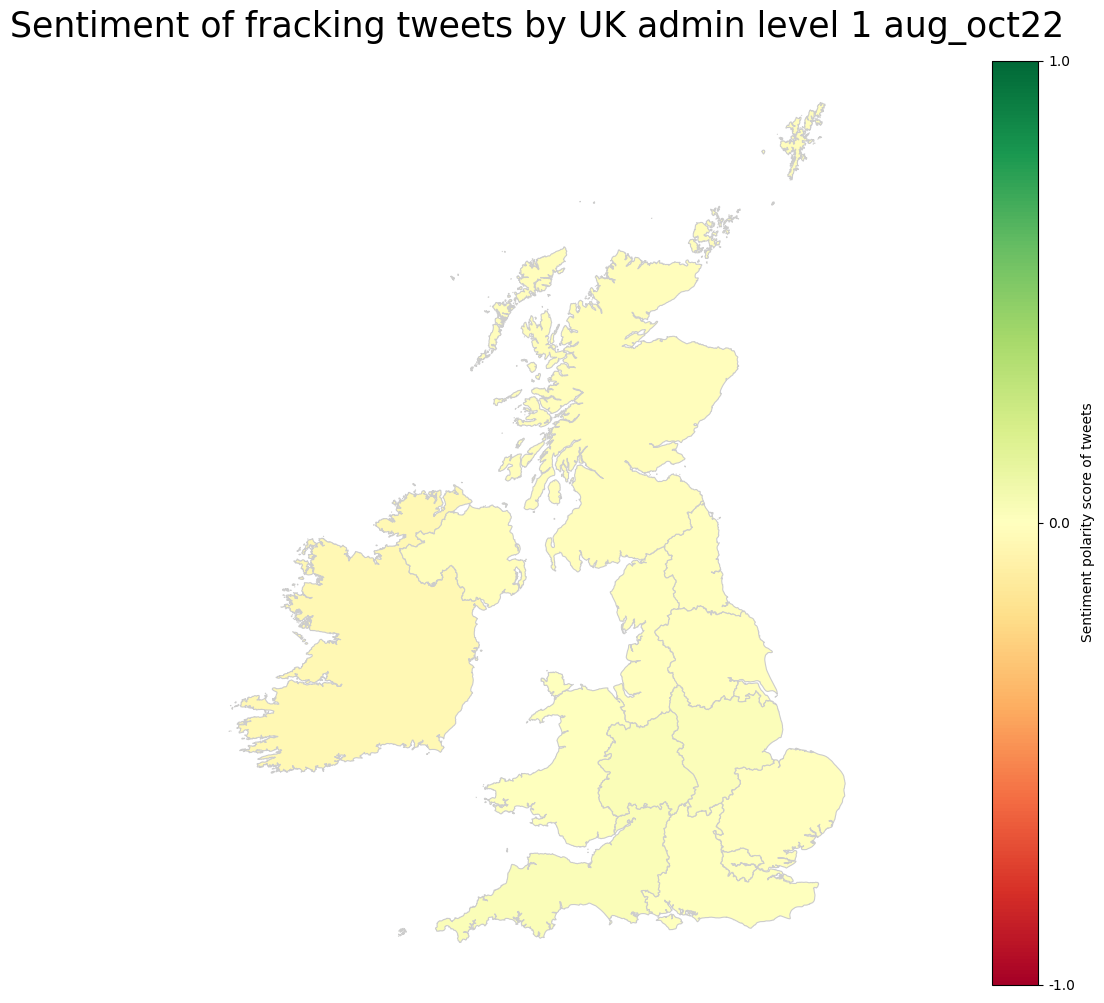

In [33]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'compound'

# set the range for the choropleth
vmin, vmax = -1, 1

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

mergedsent_europe.plot(column=variable, cmap='RdYlGn', linewidth=0.8, ax=ax, vmin=vmin, vmax=vmax, edgecolor='0.8')

# remove the axis
ax.axis('off')

# add a title
title = 'Sentiment of fracking tweets by UK admin level 1 ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})

# create an annotation for the data source
#ax.annotate('Using located tweets containing the keyword "fracking" in english',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Sentiment polarity score of tweets', format='%0.01f', ticks=[-1,0,1], ax=ax)

#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_sentiment_europe_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

In [34]:
mergedsent_europe['neg'].min(numeric_only=True), mergedsent_europe['neg'].max(numeric_only=True)

(0.08778179133858269, 0.10549154334038055)

In [35]:
mergedsent_europe['pos'].min(numeric_only=True), mergedsent_europe['pos'].max(numeric_only=True)

(0.09125211317210612, 0.09805344488188976)

#### Now have a go at plotting 'neg' and 'pos' sentiment values in two subplots, side by side.

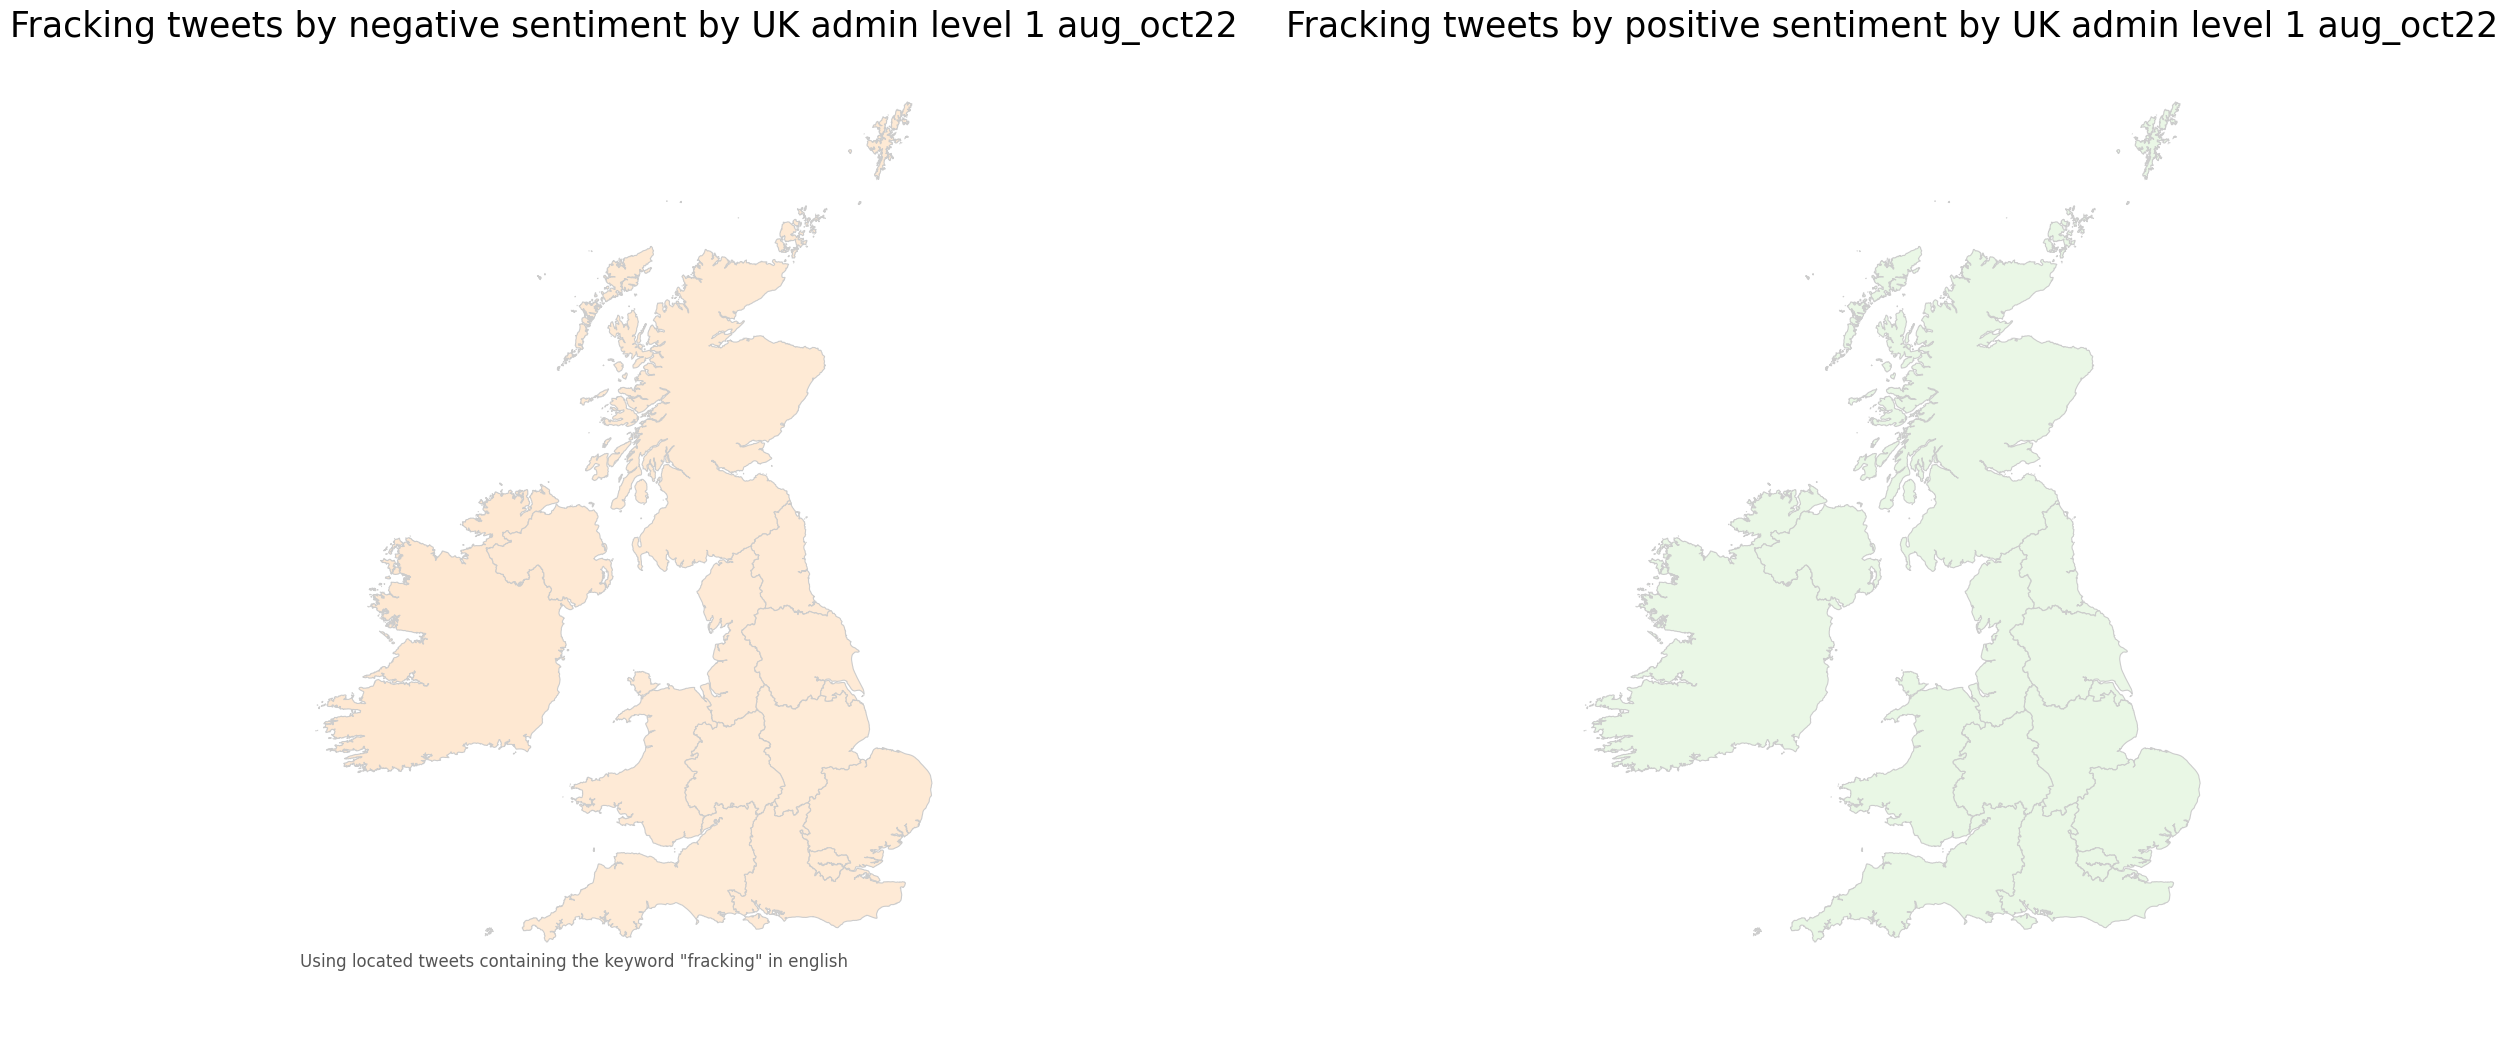

In [36]:
# set a variable that will call whatever column we want to visualise on the map
variable1 = 'neg'
variable2 = 'pos'

# set the range for the choropleth
vmin, vmax = 0,1

# create figure and axes for Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,12))

mergedsent_europe.plot(column=variable1, cmap='Oranges', linewidth=0.8, ax=ax1, vmin=vmin, vmax=vmax, edgecolor='0.8')
mergedsent_europe.plot(column=variable2, cmap='Greens', linewidth=0.8, ax=ax2, vmin=vmin, vmax=vmax, edgecolor='0.8')

# remove the axis
ax1.axis('off')
ax2.axis('off')

# add a title
title1 = 'Fracking tweets by negative sentiment by UK admin level 1 ' + date
title2 = 'Fracking tweets by positive sentiment by UK admin level 1 ' + date
ax1.set_title(title1, fontdict={'fontsize': '25', 'fontweight' : '3'})
ax2.set_title(title2, fontdict={'fontsize': '25', 'fontweight' : '3'})

# create an annotation for the data source
plt.annotate('Using located tweets containing the keyword "fracking" in english',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = plt.colorbar(sm, label=r'Sentiment polarity score of tweets', format='%0.01f', ticks=[0,1], ax=ax)

#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_sentiment_europe_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

### Now let's use the European country admin level 3 shapefile for a specific date in the dataset

In [37]:
# Get the nuts level 3 shapefile and use geopandas to create the geodataframe
europe_L3 = "/Users/mds228/social_sensing/mapping/ref-nuts-2016-01m.shp/NUTS_RG_01M_2016_3035_LEVL_3.shp/NUTS_RG_01M_2016_3035_LEVL_3.shp"
map_europe_L3 = gpd.read_file(europe_L3)
map_europe_L3.head()

LEVL_CODE NUTS_ID CNTR_CODE                    NAME_LATN  \
0          3   HR043        HR  Krapinsko-zagorska županija   
1          3   AT314        AT              Steyr-Kirchdorf   
2          3   AT315        AT                 Traunviertel   
3          3   DE600        DE                      Hamburg   
4          3   DE711        DE  Darmstadt, Kreisfreie Stadt   

                     NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
0  Krapinsko-zagorska županija           4          3           3  HR043   
1              Steyr-Kirchdorf           3          3           3  AT314   
2                 Traunviertel           3          3           3  AT315   
3                      Hamburg           4          1           1  DE600   
4  Darmstadt, Kreisfreie Stadt           4          1           3  DE711   

                                            geometry  
0  POLYGON ((4804561.671 2571296.690, 4803972.323...  
1  POLYGON ((4654776.821 2787028.403, 4653848.194...  
2  POLYGON ((4600506.892 2785382.198, 4600808.292...  
3  MULTIPOLYGON (((4317387.771 3393934.851, 43177...  
4  POLYGON ((4229546.152 2983211.570, 4230168.376...

In [38]:
#mDecide what specific date you would like to plot tweets for. Use format yyyymmdd.
specific_date = '20221019'
# boolean variable that gives us the option to plot for a spcific date or for the whole dataset
use_date = True

In [39]:
gdf_europe_L3 = gdf.to_crs(epsg=3035)
tweets_europe_L3 = gpd.sjoin(gdf_europe_L3, map_europe_L3, how="inner", predicate='intersects')
if use_date:
    tweets_europe_L3 = tweets_europe_L3[tweets_europe_L3.source_date == specific_date]
tweets_europe_L3.head()

source_id   source    hazard source_date    source_timestamp  \
19925  1582528544487636992  twitter  fracking    20221019 2022-10-19 00:26:21   
19917  1582557727536353280  twitter  fracking    20221019 2022-10-19 02:22:19   
19913  1582565807862579200  twitter  fracking    20221019 2022-10-19 02:54:25   
19912  1582570001470398464  twitter  fracking    20221019 2022-10-19 03:11:05   
19871  1582611865447768064  twitter  fracking    20221019 2022-10-19 05:57:26   

                                             source_text  \
19925  Hello @MaryRobinson01 fracking creates earthqu...   
19917  So the government that now supports fracking i...   
19913  What is this crap from the Tories to put frack...   
19912  @EmRoman74 The comment on fracking is accurate...   
19871  @QuentinFisher9 @SHEFFALCAMPBELL @MetricSqLtd ...   

                                             source_json  \
19925  {"text": "Hello @MaryRobinson01 fracking creat...   
19917  {"text": "So the government that now supports ...   
19913  {"source": "Twitter for Android", "public_metr...   
19912  {"source": "Twitter Web App", "public_metrics"...   
19871  {"lang": "en", "entities": {"annotations": [{"...   

                                             source_html  \
19925  <blockquote class='missing'>This tweet is no l...   
19917  <blockquote class='missing'>This tweet is no l...   
19913  <blockquote class='missing'>This tweet is no l...   
19912  <blockquote class='missing'>This tweet is no l...   
19871  <blockquote class='missing'>This tweet is no l...   

                                                location  warning  ...  \
19925  POLYGON ((-2.18743 53.53095, -2.18743 53.43095...        0  ...   
19917  POLYGON ((-2.18743 53.53095, -2.18743 53.43095...        0  ...   
19913  POLYGON ((-1.535556881407715 53.35850191331585...        0  ...   
19912  MULTIPOLYGON (((-3.134270812661835 53.25510840...        0  ...   
19871  POLYGON ((-2.2874299999999996 53.53095, -2.187...        0  ...   

      index_right  LEVL_CODE  NUTS_ID  CNTR_CODE  \
19925        1317          3    UKD35         UK   
19917        1317          3    UKD35         UK   
19913        1317          3    UKD35         UK   
19912        1317          3    UKD35         UK   
19871        1317          3    UKD35         UK   

                           NAME_LATN                      NUTS_NAME  \
19925  Greater Manchester South East  Greater Manchester South East   
19917  Greater Manchester South East  Greater Manchester South East   
19913  Greater Manchester South East  Greater Manchester South East   
19912  Greater Manchester South East  Greater Manchester South East   
19871  Greater Manchester South East  Greater Manchester South East   

      MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  
19925          4          1           2  UKD35  
19917          4          1           2  UKD35  
19913          4          1           2  UKD35  
19912          4          1           2  UKD35  
19871          4          1           2  UKD35  

[5 rows x 27 columns]

In [40]:
#option to save output to csv again
#tweets_europe_L3.to_csv("/Users/mds228/social_sensing/fracking_tweets/fracking_local_europeL3_" + specific_date + ".csv")

In [41]:
tweets_europe_by_country_L3 = tweets_europe_L3.groupby( [ "NUTS_NAME"] ).size().to_frame(name = 'count').reset_index()
tweets_europe_by_country_L3

NUTS_NAME  count
0         Aberdeen City and Aberdeenshire     50
1                   Angus and Dundee City     35
2                 Antrim and Newtownabbey     60
3                     Ards and North Down     64
4    Armagh City, Banbridge and Craigavon     21
..                                    ...    ...
180                          Wiltshire CC    417
181                                Wirral    222
182                         Wolverhampton    133
183                        Worcestershire    421
184                                  York    315

[185 rows x 2 columns]

In [42]:
# joining the geodataframe with the cleaned up csv dataframe
merged_europe_L3 = map_europe_L3.set_index('NUTS_NAME').join(tweets_europe_by_country_L3.set_index('NUTS_NAME'))
#.head() returns the top 5(by default ) lines of the dataframe
merged_europe_L3.max(numeric_only=True)

LEVL_CODE        3.0
MOUNT_TYPE       4.0
URBN_TYPE        3.0
COAST_TYPE       3.0
count         1781.0
dtype: float64

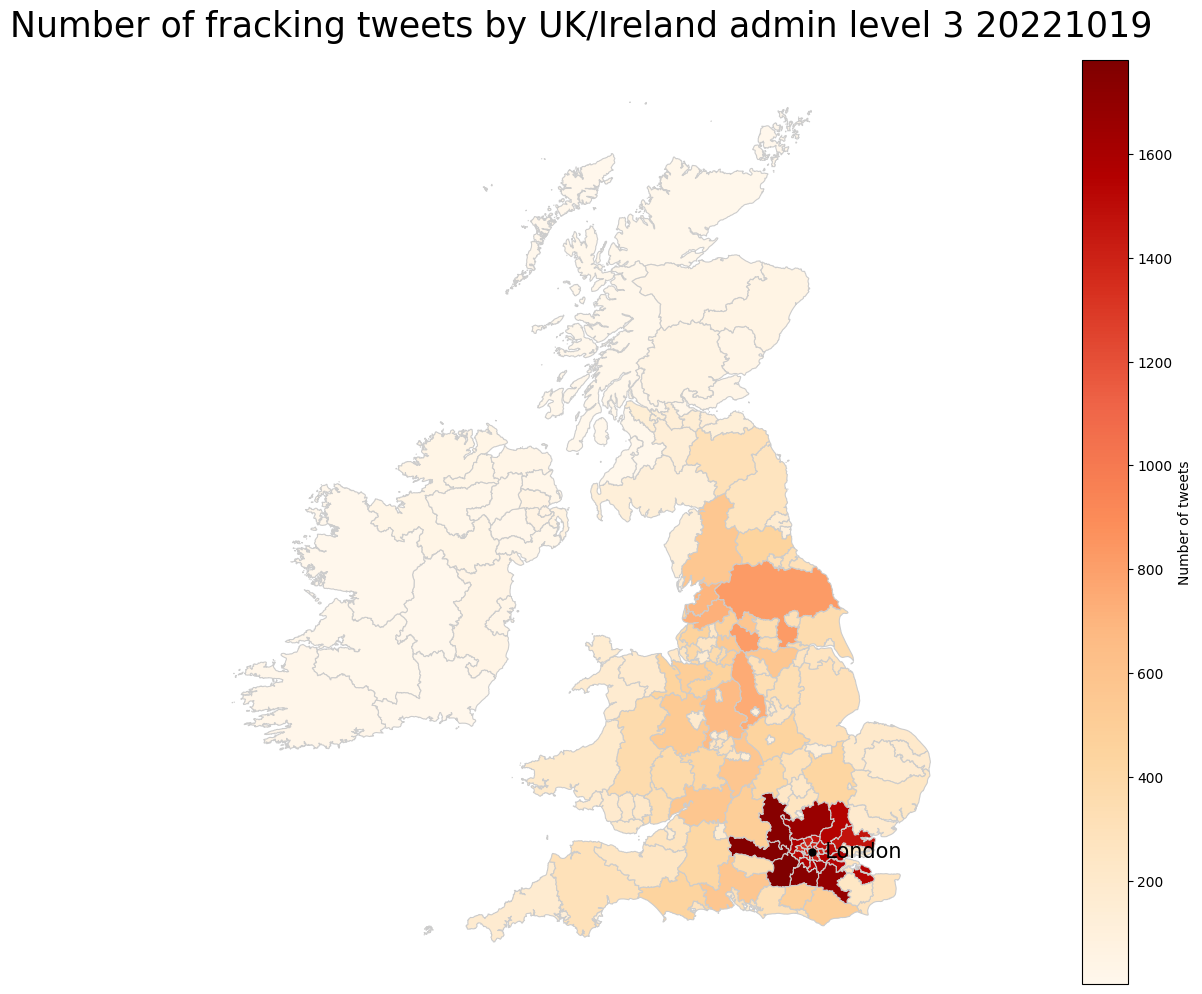

In [43]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'count'
# set the range for the choropleth
vmin, vmax = merged_europe_L3['count'].min(), merged_europe_L3['count'].max()
# set date variable to use in title and filename
if use_date:
    date = specific_date
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

merged_europe_L3.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.plot(3621142.41, 3204082.16, markersize=5, marker='o', color='black')       ##transform long and lat co-ordinates to EPSG 3035 using https://epsg.io/transform
ax.text(3621142.41, 3204082.16, '  London', color='black', size=15, ha='left', va='center')

#plt.xlim(2000000,7500000)
#plt.ylim(1000000,6000000)
# remove the axis
ax.axis('off')
# add a title
title = 'Number of fracking tweets by UK/Ireland admin level 3 ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
#ax.annotate('using geolocated tweets containing heatwave related keywords in english, dutch and greek',xy=(0.02, .02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Number of tweets', format='%1.0f', ax=ax)
#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_europeL3_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

### Plot sentiment ('compound') for this date as well

In [44]:
# group mean compound sentiment by NUTS_NAME
tweetsent_europe_L3 = tweets_europe_L3.groupby("NUTS_NAME")['compound'].mean().reset_index()
tweetsent_europe_L3.head()

NUTS_NAME  compound
0       Aberdeen City and Aberdeenshire -0.004310
1                 Angus and Dundee City -0.091503
2               Antrim and Newtownabbey -0.133012
3                   Ards and North Down -0.101619
4  Armagh City, Banbridge and Craigavon -0.177400

In [45]:
# joining the geodataframe with the cleaned up csv dataframe
mergedsent_europe_L3 = map_europe_L3.set_index('NUTS_NAME').join(tweetsent_europe_L3.set_index('NUTS_NAME'))
#.head() returns the top 5(by default ) lines of the dataframe
mergedsent_europe_L3.head()

LEVL_CODE NUTS_ID CNTR_CODE  \
NUTS_NAME                                                      
A Coruña                                 3   ES111        ES   
Aargau                                   3   CH033        CH   
Aberdeen City and Aberdeenshire          3   UKM50        UK   
Achterhoek                               3   NL225        NL   
Adana                                    3   TR621        TR   

                                                       NAME_LATN  MOUNT_TYPE  \
NUTS_NAME                                                                      
A Coruña                                                A Coruña           2   
Aargau                                                    Aargau           3   
Aberdeen City and Aberdeenshire  Aberdeen City and Aberdeenshire           4   
Achterhoek                                            Achterhoek           4   
Adana                                                      Adana           2   

                                 URBN_TYPE  COAST_TYPE    FID  \
NUTS_NAME                                                       
A Coruña                                 2           1  ES111   
Aargau                                   1           0  CH033   
Aberdeen City and Aberdeenshire          2           1  UKM50   
Achterhoek                               2           3  NL225   
Adana                                    1           1  TR621   

                                                                          geometry  \
NUTS_NAME                                                                            
A Coruña                         MULTIPOLYGON (((2906664.986 2459935.701, 29066...   
Aargau                           POLYGON ((4202525.682 2718363.053, 4201914.088...   
Aberdeen City and Aberdeenshire  POLYGON ((3564651.012 3804905.275, 3564487.159...   
Achterhoek                       POLYGON ((4099187.351 3228125.133, 4098844.825...   
Adana                            MULTIPOLYGON (((6514410.791 1997926.749, 65178...   

                                 compound  
NUTS_NAME                                  
A Coruña                              NaN  
Aargau                                NaN  
Aberdeen City and Aberdeenshire  -0.00431  
Achterhoek                            NaN  
Adana                                 NaN

In [46]:
mergedsent_europe_L3['compound'].min(numeric_only=True), mergedsent_europe_L3['compound'].max(numeric_only=True)

(-0.5707, 0.4019)

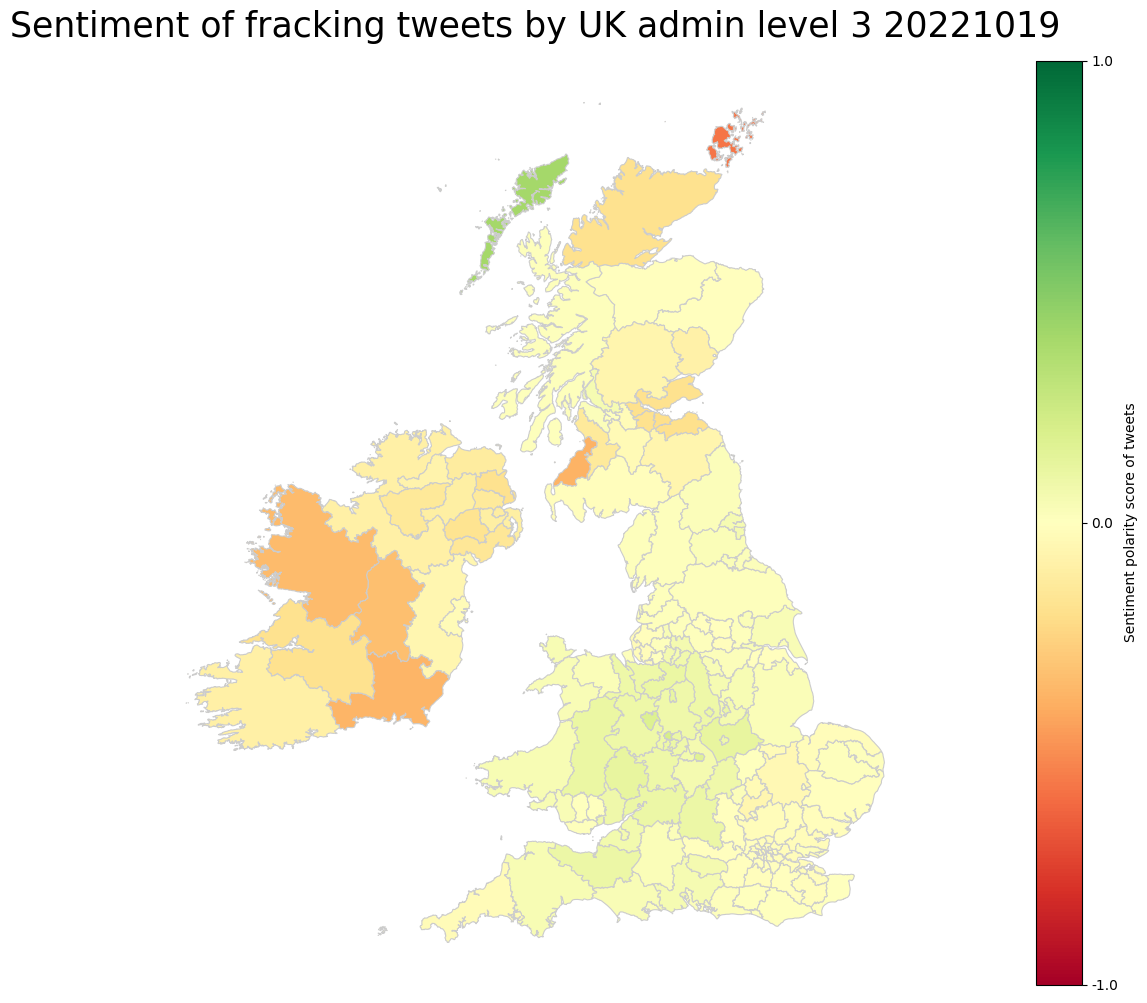

In [47]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'compound'
# set the range for the choropleth
vmin, vmax = -1, 1
# set date variable to use in title and filename
if use_date:
    date = specific_date
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

mergedsent_europe_L3.plot(column=variable, cmap='RdYlGn', linewidth=0.8, ax=ax, vmin=vmin, vmax=vmax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
title = 'Sentiment of fracking tweets by UK admin level 3 ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
#ax.annotate('Source: London Datastore, 2021',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Sentiment polarity score of tweets', format='%0.01f', ticks=[-1,0,1], ax=ax)
#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_sentiment_europeL3_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

### Plot negative tweets only

In [48]:
tweets_europe_L3_neg = tweets_europe_L3[tweets_europe_L3['compound'] < 0]
tweets_europe_L3_neg.head()

source_id   source    hazard source_date    source_timestamp  \
19917  1582557727536353280  twitter  fracking    20221019 2022-10-19 02:22:19   
19913  1582565807862579200  twitter  fracking    20221019 2022-10-19 02:54:25   
19912  1582570001470398464  twitter  fracking    20221019 2022-10-19 03:11:05   
19871  1582611865447768064  twitter  fracking    20221019 2022-10-19 05:57:26   
19852  1582617656586342400  twitter  fracking    20221019 2022-10-19 06:20:27   

                                             source_text  \
19917  So the government that now supports fracking i...   
19913  What is this crap from the Tories to put frack...   
19912  @EmRoman74 The comment on fracking is accurate...   
19871  @QuentinFisher9 @SHEFFALCAMPBELL @MetricSqLtd ...   
19852  Labour urges Tories to back vote on fracking b...   

                                             source_json  \
19917  {"text": "So the government that now supports ...   
19913  {"source": "Twitter for Android", "public_metr...   
19912  {"source": "Twitter Web App", "public_metrics"...   
19871  {"lang": "en", "entities": {"annotations": [{"...   
19852  {"text": "Labour urges Tories to back vote on ...   

                                             source_html  \
19917  <blockquote class='missing'>This tweet is no l...   
19913  <blockquote class='missing'>This tweet is no l...   
19912  <blockquote class='missing'>This tweet is no l...   
19871  <blockquote class='missing'>This tweet is no l...   
19852  <blockquote class='missing'>This tweet is no l...   

                                                location  warning  ...  \
19917  POLYGON ((-2.18743 53.53095, -2.18743 53.43095...        0  ...   
19913  POLYGON ((-1.535556881407715 53.35850191331585...        0  ...   
19912  MULTIPOLYGON (((-3.134270812661835 53.25510840...        0  ...   
19871  POLYGON ((-2.2874299999999996 53.53095, -2.187...        0  ...   
19852  MULTIPOLYGON (((-3.1318420392165307 53.2583824...        0  ...   

      index_right  LEVL_CODE  NUTS_ID  CNTR_CODE  \
19917        1317          3    UKD35         UK   
19913        1317          3    UKD35         UK   
19912        1317          3    UKD35         UK   
19871        1317          3    UKD35         UK   
19852        1317          3    UKD35         UK   

                           NAME_LATN                      NUTS_NAME  \
19917  Greater Manchester South East  Greater Manchester South East   
19913  Greater Manchester South East  Greater Manchester South East   
19912  Greater Manchester South East  Greater Manchester South East   
19871  Greater Manchester South East  Greater Manchester South East   
19852  Greater Manchester South East  Greater Manchester South East   

      MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  
19917          4          1           2  UKD35  
19913          4          1           2  UKD35  
19912          4          1           2  UKD35  
19871          4          1           2  UKD35  
19852          4          1           2  UKD35  

[5 rows x 27 columns]

In [49]:
tweetsent_europe_L3_neg = tweets_europe_L3_neg.groupby('NUTS_NAME')['compound'].mean().reset_index()
tweetsent_europe_L3_neg.head()

NUTS_NAME  compound
0       Aberdeen City and Aberdeenshire -0.514433
1                 Angus and Dundee City -0.559520
2               Antrim and Newtownabbey -0.597219
3                   Ards and North Down -0.596007
4  Armagh City, Banbridge and Craigavon -0.595620

In [50]:
# joining the geodataframe with the cleaned up csv dataframe
mergedsent_europe_L3_neg = map_europe_L3.set_index('NUTS_NAME').join(tweetsent_europe_L3_neg.set_index('NUTS_NAME'))
#.head() returns the top 5(by default ) lines of the dataframe
mergedsent_europe_L3_neg.head()

LEVL_CODE NUTS_ID CNTR_CODE  \
NUTS_NAME                                                      
A Coruña                                 3   ES111        ES   
Aargau                                   3   CH033        CH   
Aberdeen City and Aberdeenshire          3   UKM50        UK   
Achterhoek                               3   NL225        NL   
Adana                                    3   TR621        TR   

                                                       NAME_LATN  MOUNT_TYPE  \
NUTS_NAME                                                                      
A Coruña                                                A Coruña           2   
Aargau                                                    Aargau           3   
Aberdeen City and Aberdeenshire  Aberdeen City and Aberdeenshire           4   
Achterhoek                                            Achterhoek           4   
Adana                                                      Adana           2   

                                 URBN_TYPE  COAST_TYPE    FID  \
NUTS_NAME                                                       
A Coruña                                 2           1  ES111   
Aargau                                   1           0  CH033   
Aberdeen City and Aberdeenshire          2           1  UKM50   
Achterhoek                               2           3  NL225   
Adana                                    1           1  TR621   

                                                                          geometry  \
NUTS_NAME                                                                            
A Coruña                         MULTIPOLYGON (((2906664.986 2459935.701, 29066...   
Aargau                           POLYGON ((4202525.682 2718363.053, 4201914.088...   
Aberdeen City and Aberdeenshire  POLYGON ((3564651.012 3804905.275, 3564487.159...   
Achterhoek                       POLYGON ((4099187.351 3228125.133, 4098844.825...   
Adana                            MULTIPOLYGON (((6514410.791 1997926.749, 65178...   

                                 compound  
NUTS_NAME                                  
A Coruña                              NaN  
Aargau                                NaN  
Aberdeen City and Aberdeenshire -0.514433  
Achterhoek                            NaN  
Adana                                 NaN

In [51]:
mergedsent_europe_L3_neg['compound'].min(numeric_only=True), mergedsent_europe_L3_neg['compound'].max(numeric_only=True)

(-0.699025, -0.40634)

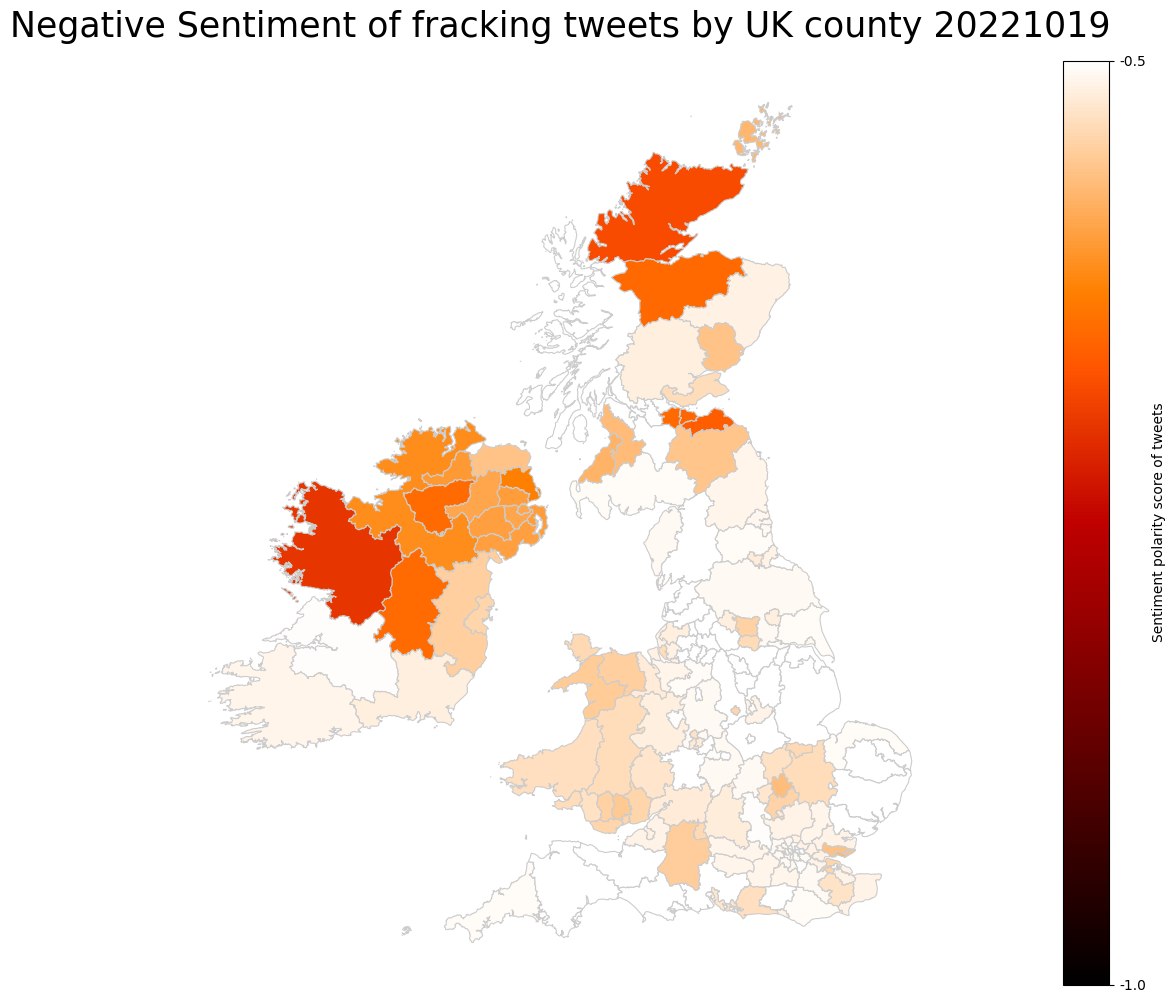

In [52]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'compound'
# set the range for the choropleth
vmin, vmax = -1,-0.5
#vmin, vmax = mergedsent_uk['compound'].min(numeric_only=True), mergedsent_uk['compound'].max(numeric_only=True)
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

mergedsent_europe_L3_neg.plot(column=variable, cmap='gist_heat', linewidth=0.8, ax=ax, vmin=vmin, vmax=vmax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
title = 'Negative Sentiment of fracking tweets by UK county ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
#ax.annotate('Source: London Datastore, 2021',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='gist_heat', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Sentiment polarity score of tweets', format='%0.1f', ticks=[-1, -0.5], ax=ax)
#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_sentiment_uk_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

### Plot Positive tweets only

In [53]:
tweets_europe_L3_pos = tweets_europe_L3[tweets_europe_L3['compound'] > 0]
tweets_europe_L3_pos.head()

source_id   source    hazard source_date    source_timestamp  \
19925  1582528544487636992  twitter  fracking    20221019 2022-10-19 00:26:21   
19869  1582611963284185089  twitter  fracking    20221019 2022-10-19 05:57:50   
19859  1582615682407370752  twitter  fracking    20221019 2022-10-19 06:12:36   
19856  1582616158238171137  twitter  fracking    20221019 2022-10-19 06:14:30   
19768  1582629600248483841  twitter  fracking    20221019 2022-10-19 07:07:55   

                                             source_text  \
19925  Hello @MaryRobinson01 fracking creates earthqu...   
19869  Fracking caused daily earthquakes at UK’s only...   
19859  Do you smell another U Turn?\nI hope so\n Frac...   
19856  The Conservative Party doesn't care about dail...   
19768  The ever-changing residents of  @10DowningStre...   

                                             source_json  \
19925  {"text": "Hello @MaryRobinson01 fracking creat...   
19869  {"lang": "en", "entities": {"annotations": [{"...   
19859  {"public_metrics": {"retweet_count": 1, "reply...   
19856  {"public_metrics": {"retweet_count": 0, "reply...   
19768  {"text": "The ever-changing residents of  @10D...   

                                             source_html  \
19925  <blockquote class='missing'>This tweet is no l...   
19869  <blockquote class='missing'>This tweet is no l...   
19859  <blockquote class='missing'>This tweet is no l...   
19856  <blockquote class='missing'>This tweet is no l...   
19768  <blockquote class='missing'>This tweet is no l...   

                                                location  warning  ...  \
19925  POLYGON ((-2.18743 53.53095, -2.18743 53.43095...        0  ...   
19869  MULTIPOLYGON (((-3.1318420392165307 53.2583824...        0  ...   
19859  MULTIPOLYGON (((0.2426641991201967 53.37276785...        0  ...   
19856  MULTIPOLYGON (((-3.1318420392165307 53.2583824...        0  ...   
19768  POLYGON ((-2.2874299999999996 53.53095, -2.187...        0  ...   

      index_right  LEVL_CODE  NUTS_ID  CNTR_CODE  \
19925        1317          3    UKD35         UK   
19869        1317          3    UKD35         UK   
19859        1317          3    UKD35         UK   
19856        1317          3    UKD35         UK   
19768        1317          3    UKD35         UK   

                           NAME_LATN                      NUTS_NAME  \
19925  Greater Manchester South East  Greater Manchester South East   
19869  Greater Manchester South East  Greater Manchester South East   
19859  Greater Manchester South East  Greater Manchester South East   
19856  Greater Manchester South East  Greater Manchester South East   
19768  Greater Manchester South East  Greater Manchester South East   

      MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  
19925          4          1           2  UKD35  
19869          4          1           2  UKD35  
19859          4          1           2  UKD35  
19856          4          1           2  UKD35  
19768          4          1           2  UKD35  

[5 rows x 27 columns]

In [54]:
tweetsent_europe_L3_pos = tweets_europe_L3_pos.groupby('NUTS_NAME')['compound'].mean().reset_index()
tweetsent_europe_L3_pos.head()

NUTS_NAME  compound
0       Aberdeen City and Aberdeenshire  0.502461
1                 Angus and Dundee City  0.471836
2               Antrim and Newtownabbey  0.419278
3                   Ards and North Down  0.435845
4  Armagh City, Banbridge and Craigavon  0.371800

In [55]:
# joining the geodataframe with the cleaned up csv dataframe
mergedsent_europe_L3_pos = map_europe_L3.set_index('NUTS_NAME').join(tweetsent_europe_L3_pos.set_index('NUTS_NAME'))
#.head() returns the top 5(by default ) lines of the dataframe
mergedsent_europe_L3_pos.head()

LEVL_CODE NUTS_ID CNTR_CODE  \
NUTS_NAME                                                      
A Coruña                                 3   ES111        ES   
Aargau                                   3   CH033        CH   
Aberdeen City and Aberdeenshire          3   UKM50        UK   
Achterhoek                               3   NL225        NL   
Adana                                    3   TR621        TR   

                                                       NAME_LATN  MOUNT_TYPE  \
NUTS_NAME                                                                      
A Coruña                                                A Coruña           2   
Aargau                                                    Aargau           3   
Aberdeen City and Aberdeenshire  Aberdeen City and Aberdeenshire           4   
Achterhoek                                            Achterhoek           4   
Adana                                                      Adana           2   

                                 URBN_TYPE  COAST_TYPE    FID  \
NUTS_NAME                                                       
A Coruña                                 2           1  ES111   
Aargau                                   1           0  CH033   
Aberdeen City and Aberdeenshire          2           1  UKM50   
Achterhoek                               2           3  NL225   
Adana                                    1           1  TR621   

                                                                          geometry  \
NUTS_NAME                                                                            
A Coruña                         MULTIPOLYGON (((2906664.986 2459935.701, 29066...   
Aargau                           POLYGON ((4202525.682 2718363.053, 4201914.088...   
Aberdeen City and Aberdeenshire  POLYGON ((3564651.012 3804905.275, 3564487.159...   
Achterhoek                       POLYGON ((4099187.351 3228125.133, 4098844.825...   
Adana                            MULTIPOLYGON (((6514410.791 1997926.749, 65178...   

                                 compound  
NUTS_NAME                                  
A Coruña                              NaN  
Aargau                                NaN  
Aberdeen City and Aberdeenshire  0.502461  
Achterhoek                            NaN  
Adana                                 NaN

In [56]:
mergedsent_europe_L3_pos['compound'].min(numeric_only=True), mergedsent_europe_L3_pos['compound'].max(numeric_only=True)

(0.2115, 0.5591979591836734)

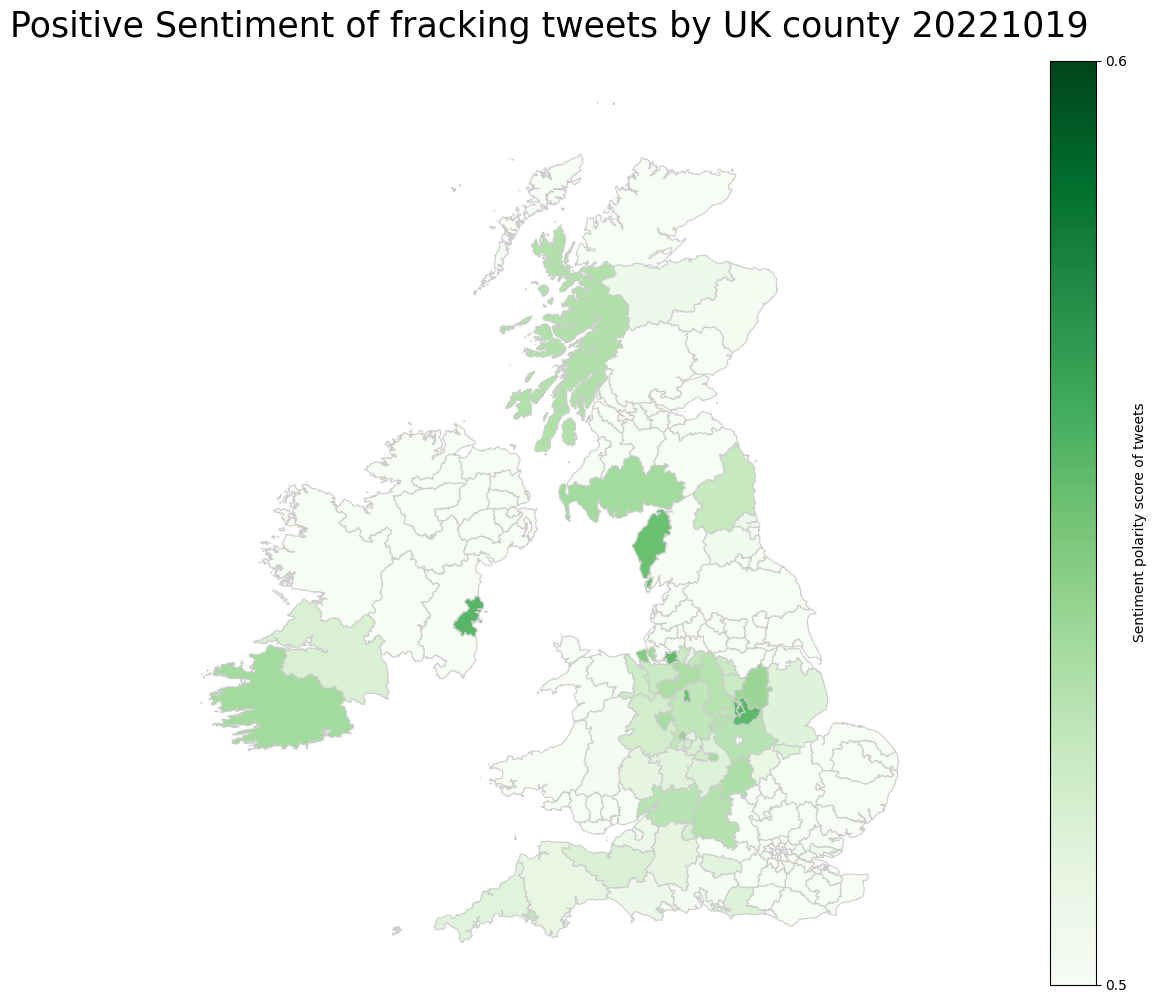

In [57]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'compound'
# set the range for the choropleth
vmin, vmax = 0.5,0.6
#vmin, vmax = mergedsent_uk['compound'].min(numeric_only=True), mergedsent_uk['compound'].max(numeric_only=True)
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

mergedsent_europe_L3_pos.plot(column=variable, cmap='Greens', linewidth=0.8, ax=ax, vmin=vmin, vmax=vmax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
title = 'Positive Sentiment of fracking tweets by UK county ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
#ax.annotate('Source: London Datastore, 2021',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Sentiment polarity score of tweets', format='%0.1f', ticks = [0.5,0.6], ax=ax)
#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_sentiment_uk_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

## Tweets by UK counties (should only show UK incl Northern Ireland - excludes Republic of Ireland)

In [58]:
uk_counties = '/Users/mds228/social_sensing/mapping/Counties_and_Unitary_Authorities_(December_2019)_Boundaries_UK_BUC/Counties_and_Unitary_Authorities_(December_2019)_Boundaries_UK_BUC.shp'
map_uk = gpd.read_file(uk_counties)
map_uk.head()

objectid  ctyua19cd             ctyua19nm ctyua19nmw   bng_e   bng_n  \
0         1  E06000001            Hartlepool        NaN  447160  531474   
1         2  E06000002         Middlesbrough        NaN  451141  516887   
2         3  E06000003  Redcar and Cleveland        NaN  464361  519597   
3         4  E06000004      Stockton-on-Tees        NaN  444940  518183   
4         5  E06000005            Darlington        NaN  428029  515648   

      long        lat    st_areasha    st_lengths  \
0 -1.27018  54.676140  9.684551e+07  50305.325058   
1 -1.21099  54.544670  5.290846e+07  34964.406313   
2 -1.00608  54.567520  2.486791e+08  83939.752513   
3 -1.30664  54.556911  2.071591e+08  87075.860824   
4 -1.56835  54.535339  1.988128e+08  91926.839545   

                                            geometry  
0  POLYGON ((448986.025 536729.674, 453194.600 53...  
1  POLYGON ((451752.698 520561.900, 452424.399 52...  
2  POLYGON ((451965.636 521061.756, 454348.400 52...  
3  POLYGON ((451965.636 521061.756, 451752.698 52...  
4  POLYGON ((419709.299 515678.298, 419162.998 51...

In [59]:
gdf_uk = gdf.to_crs(epsg=27700)
tweets_uk = gpd.sjoin(gdf_uk, map_uk, how="inner", predicate='intersects')
tweets_uk.head()

source_id   source    hazard source_date    source_timestamp  \
6305  1553901074674634752  twitter  fracking    20220801 2022-08-01 00:31:00   
6259  1554238590846124034  twitter  fracking    20220801 2022-08-01 22:52:11   
6215  1554436546765492224  twitter  fracking    20220802 2022-08-02 11:58:47   
6211  1554447530200629249  twitter  fracking    20220802 2022-08-02 12:42:26   
6193  1554520962393047046  twitter  fracking    20220802 2022-08-02 17:34:13   

                                            source_text  \
6305  @DefiantLs NO HE JUST STOPS FRACKING, FURTHER ...   
6259  For all their talk about being the best candid...   
6215  @LanceForman @BenGoldsmith @CAR26_ORG Fracking...   
6211  @MikelGunners @TomsTeamTalk @zarahsultana Of w...   
6193  @chrisgreybrexit Children’s future when you ar...   

                                            source_json  \
6305  {"author_id": "1520643265480957953", "lang": "...   
6259  {"text": "For all their talk about being the b...   
6215  {"author_id": "534784057", "id": "155443654676...   
6211  {"referenced_tweets": [{"type": "replied_to", ...   
6193  {"entities": {"annotations": [{"start": 125, "...   

                                            source_html  \
6305  <blockquote class='missing'>This tweet is no l...   
6259  <blockquote class='missing'>This tweet is no l...   
6215  <blockquote class='missing'>This tweet is no l...   
6211  <blockquote class='missing'>This tweet is no l...   
6193  <blockquote class='missing'>This tweet is no l...   

                                               location  warning  ...  \
6305  POLYGON ((-2.2874299999999996 53.43095, -2.287...        0  ...   
6259  POLYGON ((-2.18743 53.53095, -2.18743 53.43095...        0  ...   
6215  POLYGON ((-2.6633674048504905 53.3671120235848...        0  ...   
6211  MULTIPOLYGON (((-3.134270812661835 53.25510840...        0  ...   
6193  POLYGON ((-2.2874299999999996 53.53095, -2.187...        0  ...   

     objectid  ctyua19cd  ctyua19nm  ctyua19nmw   bng_e   bng_n     long  \
6305       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
6259       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
6215       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
6211       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
6193       65  E08000009   Trafford         NaN  375790  391162 -2.36572   

           lat    st_areasha    st_lengths  
6305  53.41671  1.080015e+08  50772.155121  
6259  53.41671  1.080015e+08  50772.155121  
6215  53.41671  1.080015e+08  50772.155121  
6211  53.41671  1.080015e+08  50772.155121  
6193  53.41671  1.080015e+08  50772.155121  

[5 rows x 28 columns]

In [60]:
tweets_uk_by_county = tweets_uk.groupby( [ "ctyua19nm"] ).size().to_frame(name = 'count').reset_index()
tweets_uk_by_county

ctyua19nm  count
0              Aberdeen City    275
1              Aberdeenshire    396
2                      Angus    344
3    Antrim and Newtownabbey    569
4        Ards and North Down    499
..                       ...    ...
208                Wokingham   1565
209            Wolverhampton    838
210           Worcestershire   2723
211                  Wrexham   3408
212                     York   2668

[213 rows x 2 columns]

In [61]:
# joining the geodataframe with the cleaned up csv dataframe
merged_uk = map_uk.set_index('ctyua19nm').join(tweets_uk_by_county.set_index('ctyua19nm'))
#.head() returns the top 5(by default ) lines of the dataframe
merged_uk.head()

objectid  ctyua19cd ctyua19nmw   bng_e   bng_n     long  \
ctyua19nm                                                                       
Hartlepool                   1  E06000001        NaN  447160  531474 -1.27018   
Middlesbrough                2  E06000002        NaN  451141  516887 -1.21099   
Redcar and Cleveland         3  E06000003        NaN  464361  519597 -1.00608   
Stockton-on-Tees             4  E06000004        NaN  444940  518183 -1.30664   
Darlington                   5  E06000005        NaN  428029  515648 -1.56835   

                            lat    st_areasha    st_lengths  \
ctyua19nm                                                     
Hartlepool            54.676140  9.684551e+07  50305.325058   
Middlesbrough         54.544670  5.290846e+07  34964.406313   
Redcar and Cleveland  54.567520  2.486791e+08  83939.752513   
Stockton-on-Tees      54.556911  2.071591e+08  87075.860824   
Darlington            54.535339  1.988128e+08  91926.839545   

                                                               geometry  \
ctyua19nm                                                                 
Hartlepool            POLYGON ((448986.025 536729.674, 453194.600 53...   
Middlesbrough         POLYGON ((451752.698 520561.900, 452424.399 52...   
Redcar and Cleveland  POLYGON ((451965.636 521061.756, 454348.400 52...   
Stockton-on-Tees      POLYGON ((451965.636 521061.756, 451752.698 52...   
Darlington            POLYGON ((419709.299 515678.298, 419162.998 51...   

                       count  
ctyua19nm                     
Hartlepool             826.0  
Middlesbrough         2543.0  
Redcar and Cleveland  2620.0  
Stockton-on-Tees      2601.0  
Darlington            2785.0

In [62]:
#merged_uk.to_csv(outfile)

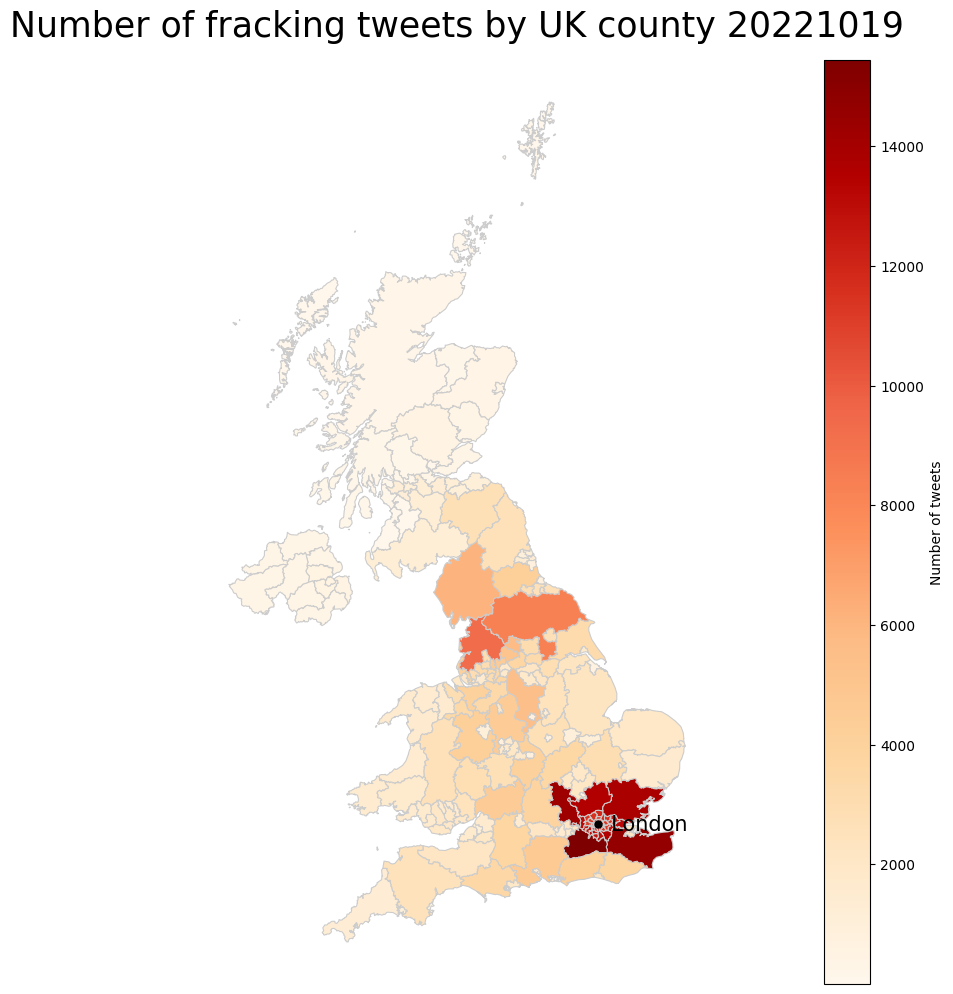

In [63]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'count'
# set the range for the choropleth
vmin, vmax = merged_uk['count'].min(), merged_uk['count'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

merged_uk.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.plot(530695.39, 180671.49, markersize=5, marker='o', color='black')       ##transform long and lat co-ordinates to EPSG 27700 using https://epsg.io/transform
ax.text(530695.39, 180671.49, '  London', color='black', size=15, ha='left', va='center')

# remove the axis
ax.axis('off')
# add a title
title = 'Number of fracking tweets by UK county ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
#ax.annotate('using geolocated tweets containing heatwave related keywords in english, dutch and greek',xy=(0, 0), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Number of tweets', format='%1.0f', ax=ax)
#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_uk_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

## SENTIMENT: United Kingdom Counties

In [64]:
tweetsent_uk = tweets_uk.groupby('ctyua19nm')['compound'].mean().reset_index()
tweetsent_uk.head()

ctyua19nm  compound
0            Aberdeen City  0.086300
1            Aberdeenshire  0.048118
2                    Angus  0.007548
3  Antrim and Newtownabbey -0.011611
4      Ards and North Down -0.027865

In [65]:
# joining the geodataframe with the cleaned up csv dataframe
mergedsent_uk = map_uk.set_index('ctyua19nm').join(tweetsent_uk.set_index('ctyua19nm'))
#.head() returns the top 5(by default ) lines of the dataframe
mergedsent_uk.head()

objectid  ctyua19cd ctyua19nmw   bng_e   bng_n     long  \
ctyua19nm                                                                       
Hartlepool                   1  E06000001        NaN  447160  531474 -1.27018   
Middlesbrough                2  E06000002        NaN  451141  516887 -1.21099   
Redcar and Cleveland         3  E06000003        NaN  464361  519597 -1.00608   
Stockton-on-Tees             4  E06000004        NaN  444940  518183 -1.30664   
Darlington                   5  E06000005        NaN  428029  515648 -1.56835   

                            lat    st_areasha    st_lengths  \
ctyua19nm                                                     
Hartlepool            54.676140  9.684551e+07  50305.325058   
Middlesbrough         54.544670  5.290846e+07  34964.406313   
Redcar and Cleveland  54.567520  2.486791e+08  83939.752513   
Stockton-on-Tees      54.556911  2.071591e+08  87075.860824   
Darlington            54.535339  1.988128e+08  91926.839545   

                                                               geometry  \
ctyua19nm                                                                 
Hartlepool            POLYGON ((448986.025 536729.674, 453194.600 53...   
Middlesbrough         POLYGON ((451752.698 520561.900, 452424.399 52...   
Redcar and Cleveland  POLYGON ((451965.636 521061.756, 454348.400 52...   
Stockton-on-Tees      POLYGON ((451965.636 521061.756, 451752.698 52...   
Darlington            POLYGON ((419709.299 515678.298, 419162.998 51...   

                      compound  
ctyua19nm                       
Hartlepool            0.024769  
Middlesbrough         0.010841  
Redcar and Cleveland  0.010014  
Stockton-on-Tees      0.009854  
Darlington            0.006281

In [66]:
mergedsent_uk.max(numeric_only=True)

objectid      2.160000e+02
bng_e         6.082190e+05
bng_n         1.180307e+06
long          1.049190e+00
lat           6.050495e+01
st_areasha    2.629180e+10
st_lengths    2.890482e+06
compound      8.630000e-02
dtype: float64

In [67]:
mergedsent_uk['compound'].min(numeric_only=True), mergedsent_uk['compound'].max(numeric_only=True)

(-0.53215, 0.08629999999999999)

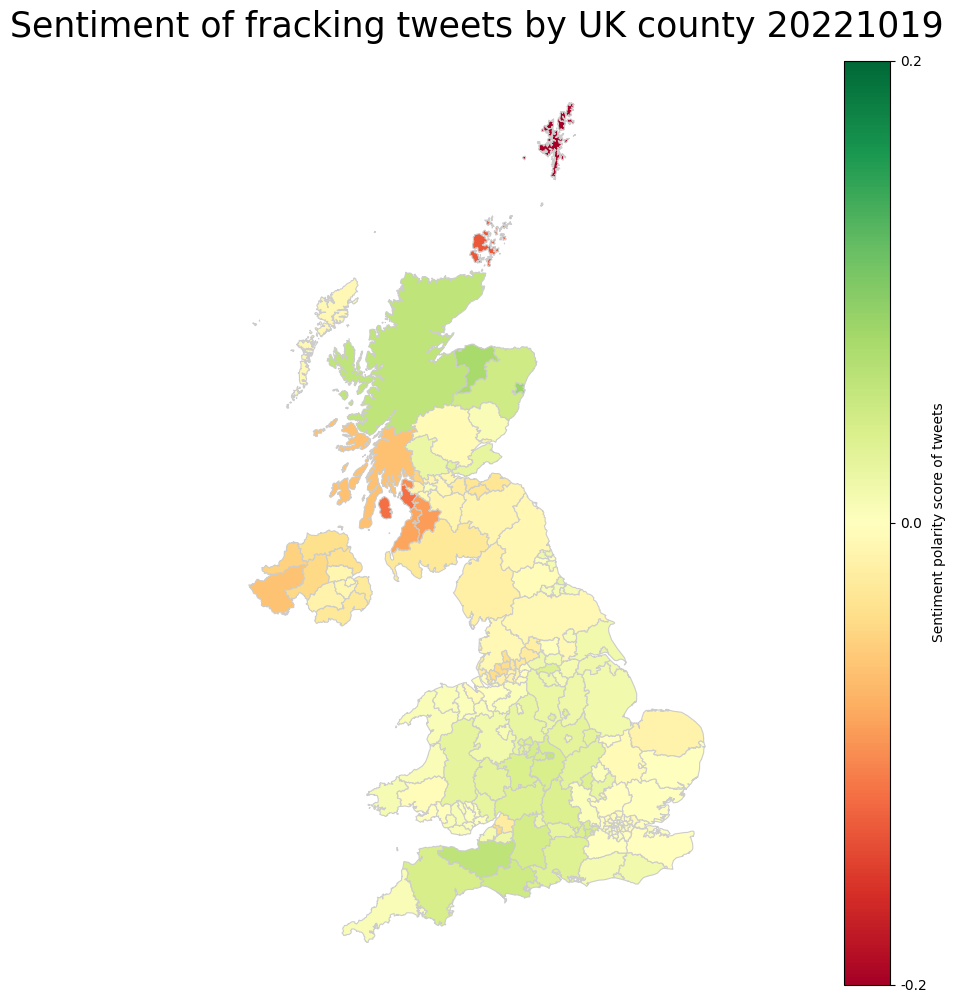

In [68]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'compound'
# set the range for the choropleth
vmin, vmax = -0.2, 0.2
#vmin, vmax = mergedsent_uk['compound'].min(numeric_only=True), mergedsent_uk['compound'].max(numeric_only=True)
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

mergedsent_uk.plot(column=variable, cmap='RdYlGn', linewidth=0.8, ax=ax, vmin=vmin, vmax=vmax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
title = 'Sentiment of fracking tweets by UK county ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
#ax.annotate('Source: London Datastore, 2021',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Sentiment polarity score of tweets', format='%0.1f', ticks=[-0.2,0,0.2], ax=ax)
#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_sentiment_uk_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

### Negative tweets

In [69]:
tweets_uk_neg = tweets_uk[tweets_uk['compound'] < 0]
tweets_uk_neg.head()

source_id   source    hazard source_date    source_timestamp  \
6305  1553901074674634752  twitter  fracking    20220801 2022-08-01 00:31:00   
6193  1554520962393047046  twitter  fracking    20220802 2022-08-02 17:34:13   
6076  1555104697459118081  twitter  fracking    20220804 2022-08-04 08:13:46   
6032  1555150148589723648  twitter  fracking    20220804 2022-08-04 11:14:23   
5982  1555193686316748800  twitter  fracking    20220804 2022-08-04 14:07:23   

                                            source_text  \
6305  @DefiantLs NO HE JUST STOPS FRACKING, FURTHER ...   
6193  @chrisgreybrexit Children’s future when you ar...   
6076  @gwithiandaze @Mike_Fabricant Oh they hate us ...   
6032  We need renewables and insulated homes not a g...   
5982  We need #renewables and insulated homes not a ...   

                                            source_json  \
6305  {"author_id": "1520643265480957953", "lang": "...   
6193  {"entities": {"annotations": [{"start": 125, "...   
6076  {"text": "@gwithiandaze @Mike_Fabricant Oh the...   
6032  {"source": "Twitter Web App", "entities": {"ha...   
5982  {"created_at": "2022-08-04T14:07:23.000Z", "co...   

                                            source_html  \
6305  <blockquote class='missing'>This tweet is no l...   
6193  <blockquote class='missing'>This tweet is no l...   
6076  <blockquote class='missing'>This tweet is no l...   
6032  <blockquote class='missing'>This tweet is no l...   
5982  <blockquote class='missing'>This tweet is no l...   

                                               location  warning  ...  \
6305  POLYGON ((-2.2874299999999996 53.43095, -2.287...        0  ...   
6193  POLYGON ((-2.2874299999999996 53.53095, -2.187...        0  ...   
6076  MULTIPOLYGON (((-3.1318420392165307 53.2583824...        0  ...   
6032  POLYGON ((-2.18743 53.53095, -2.18743 53.43095...        0  ...   
5982  POLYGON ((-2.2874299999999996 53.53095, -2.187...        0  ...   

     objectid  ctyua19cd  ctyua19nm  ctyua19nmw   bng_e   bng_n     long  \
6305       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
6193       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
6076       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
6032       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
5982       65  E08000009   Trafford         NaN  375790  391162 -2.36572   

           lat    st_areasha    st_lengths  
6305  53.41671  1.080015e+08  50772.155121  
6193  53.41671  1.080015e+08  50772.155121  
6076  53.41671  1.080015e+08  50772.155121  
6032  53.41671  1.080015e+08  50772.155121  
5982  53.41671  1.080015e+08  50772.155121  

[5 rows x 28 columns]

In [70]:
tweetsent_uk_neg = tweets_uk_neg.groupby('ctyua19nm')['compound'].mean().reset_index()
tweetsent_uk_neg.head()

ctyua19nm  compound
0            Aberdeen City -0.474054
1            Aberdeenshire -0.462548
2                    Angus -0.510100
3  Antrim and Newtownabbey -0.510232
4      Ards and North Down -0.518555

In [71]:
# joining the geodataframe with the cleaned up csv dataframe
mergedsent_uk_neg = map_uk.set_index('ctyua19nm').join(tweetsent_uk_neg.set_index('ctyua19nm'))
#.head() returns the top 5(by default ) lines of the dataframe
mergedsent_uk_neg.head()

objectid  ctyua19cd ctyua19nmw   bng_e   bng_n     long  \
ctyua19nm                                                                       
Hartlepool                   1  E06000001        NaN  447160  531474 -1.27018   
Middlesbrough                2  E06000002        NaN  451141  516887 -1.21099   
Redcar and Cleveland         3  E06000003        NaN  464361  519597 -1.00608   
Stockton-on-Tees             4  E06000004        NaN  444940  518183 -1.30664   
Darlington                   5  E06000005        NaN  428029  515648 -1.56835   

                            lat    st_areasha    st_lengths  \
ctyua19nm                                                     
Hartlepool            54.676140  9.684551e+07  50305.325058   
Middlesbrough         54.544670  5.290846e+07  34964.406313   
Redcar and Cleveland  54.567520  2.486791e+08  83939.752513   
Stockton-on-Tees      54.556911  2.071591e+08  87075.860824   
Darlington            54.535339  1.988128e+08  91926.839545   

                                                               geometry  \
ctyua19nm                                                                 
Hartlepool            POLYGON ((448986.025 536729.674, 453194.600 53...   
Middlesbrough         POLYGON ((451752.698 520561.900, 452424.399 52...   
Redcar and Cleveland  POLYGON ((451965.636 521061.756, 454348.400 52...   
Stockton-on-Tees      POLYGON ((451965.636 521061.756, 451752.698 52...   
Darlington            POLYGON ((419709.299 515678.298, 419162.998 51...   

                      compound  
ctyua19nm                       
Hartlepool           -0.474519  
Middlesbrough        -0.501893  
Redcar and Cleveland -0.503073  
Stockton-on-Tees     -0.502364  
Darlington           -0.507142

In [72]:
mergedsent_uk_neg['compound'].min(numeric_only=True), mergedsent_uk_neg['compound'].max(numeric_only=True)

(-0.5750636363636364, -0.46254834437086095)

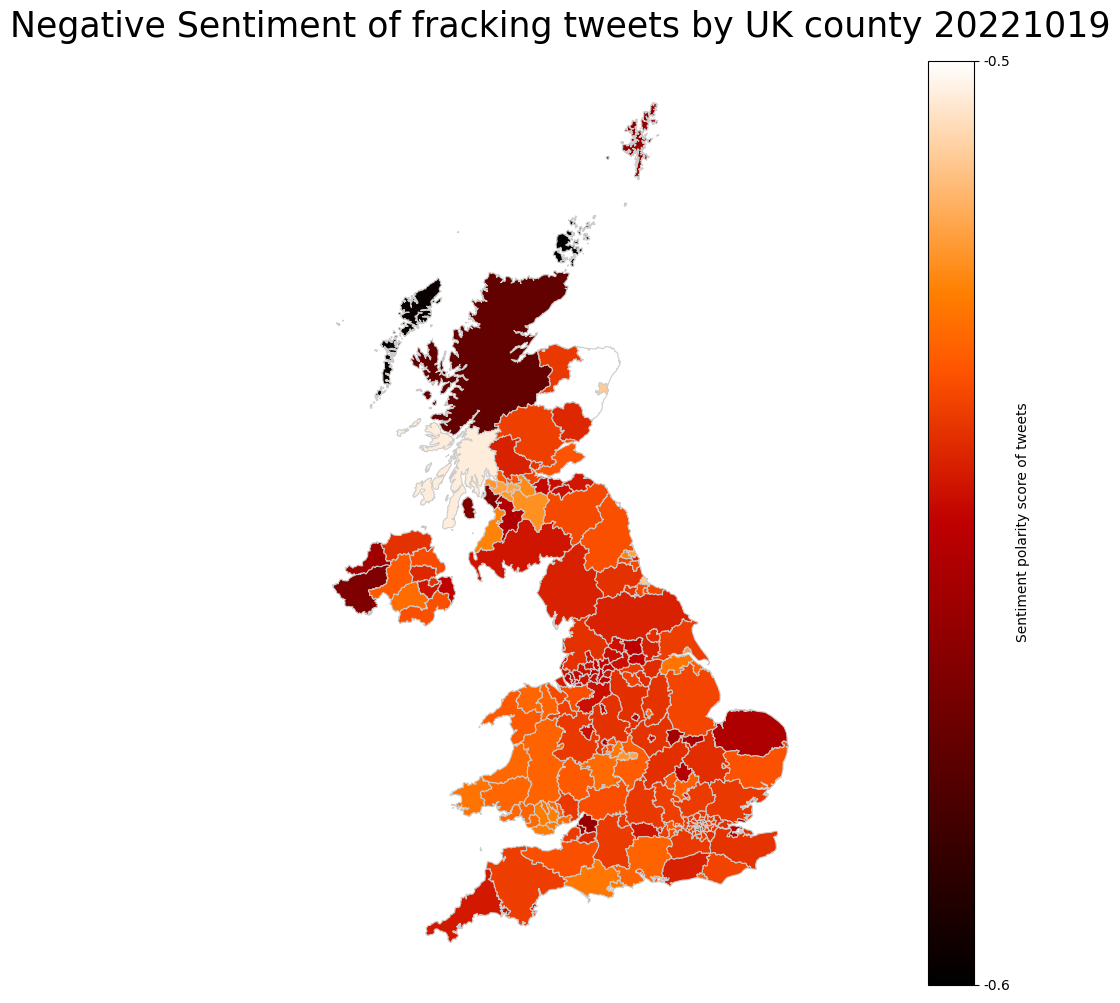

In [73]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'compound'
# set the range for the choropleth
vmin, vmax = mergedsent_uk_neg['compound'].min(numeric_only=True), mergedsent_uk_neg['compound'].max(numeric_only=True)
#vmin, vmax = mergedsent_uk['compound'].min(numeric_only=True), mergedsent_uk['compound'].max(numeric_only=True)
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

mergedsent_uk_neg.plot(column=variable, cmap='gist_heat', linewidth=0.8, ax=ax, vmin=vmin, vmax=vmax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
title = 'Negative Sentiment of fracking tweets by UK county ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
#ax.annotate('Source: London Datastore, 2021',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='gist_heat', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Sentiment polarity score of tweets', format='%0.1f', ticks=[vmin, vmax], ax=ax)
#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_sentiment_uk_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

### Positive tweets

In [74]:
tweets_uk_pos = tweets_uk[tweets_uk['compound'] > 0]
tweets_uk_pos.head()

source_id   source    hazard source_date    source_timestamp  \
6259  1554238590846124034  twitter  fracking    20220801 2022-08-01 22:52:11   
6211  1554447530200629249  twitter  fracking    20220802 2022-08-02 12:42:26   
6154  1554761632844242946  twitter  fracking    20220803 2022-08-03 09:30:34   
5746  1555273556765949952  twitter  fracking    20220804 2022-08-04 19:24:46   
5665  1555299282495983618  twitter  fracking    20220804 2022-08-04 21:06:59   

                                            source_text  \
6259  For all their talk about being the best candid...   
6211  @MikelGunners @TomsTeamTalk @zarahsultana Of w...   
6154  I wasn't going to comment on any of this stuff...   
5746  @RachelReevesMP I really hope you are not goin...   
5665  @ZackPolanski And earth tremors aren't even th...   

                                            source_json  \
6259  {"text": "For all their talk about being the b...   
6211  {"referenced_tweets": [{"type": "replied_to", ...   
6154  {"author_id": "196268381", "id": "155476163284...   
5746  {"source": "Twitter for iPhone", "public_metri...   
5665  {"lang": "en", "public_metrics": {"retweet_cou...   

                                            source_html  \
6259  <blockquote class='missing'>This tweet is no l...   
6211  <blockquote class='missing'>This tweet is no l...   
6154  <blockquote class='missing'>This tweet is no l...   
5746  <blockquote class='missing'>This tweet is no l...   
5665  <blockquote class='missing'>This tweet is no l...   

                                               location  warning  ...  \
6259  POLYGON ((-2.18743 53.53095, -2.18743 53.43095...        0  ...   
6211  MULTIPOLYGON (((-3.134270812661835 53.25510840...        0  ...   
6154  POLYGON ((-2.18743 53.53095, -2.18743 53.43095...        0  ...   
5746  POLYGON ((-2.18743 53.43095, -2.28742999999999...        0  ...   
5665  MULTIPOLYGON (((-3.1318420392165307 53.2583824...        0  ...   

     objectid  ctyua19cd  ctyua19nm  ctyua19nmw   bng_e   bng_n     long  \
6259       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
6211       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
6154       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
5746       65  E08000009   Trafford         NaN  375790  391162 -2.36572   
5665       65  E08000009   Trafford         NaN  375790  391162 -2.36572   

           lat    st_areasha    st_lengths  
6259  53.41671  1.080015e+08  50772.155121  
6211  53.41671  1.080015e+08  50772.155121  
6154  53.41671  1.080015e+08  50772.155121  
5746  53.41671  1.080015e+08  50772.155121  
5665  53.41671  1.080015e+08  50772.155121  

[5 rows x 28 columns]

In [75]:
tweetsent_uk_pos = tweets_uk_pos.groupby('ctyua19nm')['compound'].mean().reset_index()
tweetsent_uk_pos.head()

ctyua19nm  compound
0            Aberdeen City  0.513784
1            Aberdeenshire  0.502257
2                    Angus  0.486284
3  Antrim and Newtownabbey  0.454836
4      Ards and North Down  0.442397

In [76]:
# joining the geodataframe with the cleaned up csv dataframe
mergedsent_uk_pos = map_uk.set_index('ctyua19nm').join(tweetsent_uk_pos.set_index('ctyua19nm'))
#.head() returns the top 5(by default ) lines of the dataframe
mergedsent_uk_pos.head()

objectid  ctyua19cd ctyua19nmw   bng_e   bng_n     long  \
ctyua19nm                                                                       
Hartlepool                   1  E06000001        NaN  447160  531474 -1.27018   
Middlesbrough                2  E06000002        NaN  451141  516887 -1.21099   
Redcar and Cleveland         3  E06000003        NaN  464361  519597 -1.00608   
Stockton-on-Tees             4  E06000004        NaN  444940  518183 -1.30664   
Darlington                   5  E06000005        NaN  428029  515648 -1.56835   

                            lat    st_areasha    st_lengths  \
ctyua19nm                                                     
Hartlepool            54.676140  9.684551e+07  50305.325058   
Middlesbrough         54.544670  5.290846e+07  34964.406313   
Redcar and Cleveland  54.567520  2.486791e+08  83939.752513   
Stockton-on-Tees      54.556911  2.071591e+08  87075.860824   
Darlington            54.535339  1.988128e+08  91926.839545   

                                                               geometry  \
ctyua19nm                                                                 
Hartlepool            POLYGON ((448986.025 536729.674, 453194.600 53...   
Middlesbrough         POLYGON ((451752.698 520561.900, 452424.399 52...   
Redcar and Cleveland  POLYGON ((451965.636 521061.756, 454348.400 52...   
Stockton-on-Tees      POLYGON ((451965.636 521061.756, 451752.698 52...   
Darlington            POLYGON ((419709.299 515678.298, 419162.998 51...   

                      compound  
ctyua19nm                       
Hartlepool            0.469590  
Middlesbrough         0.465192  
Redcar and Cleveland  0.464871  
Stockton-on-Tees      0.465434  
Darlington            0.460493

In [77]:
mergedsent_uk_pos['compound'].min(numeric_only=True), mergedsent_uk_pos['compound'].max(numeric_only=True)

(0.4092636363636364, 0.73224)

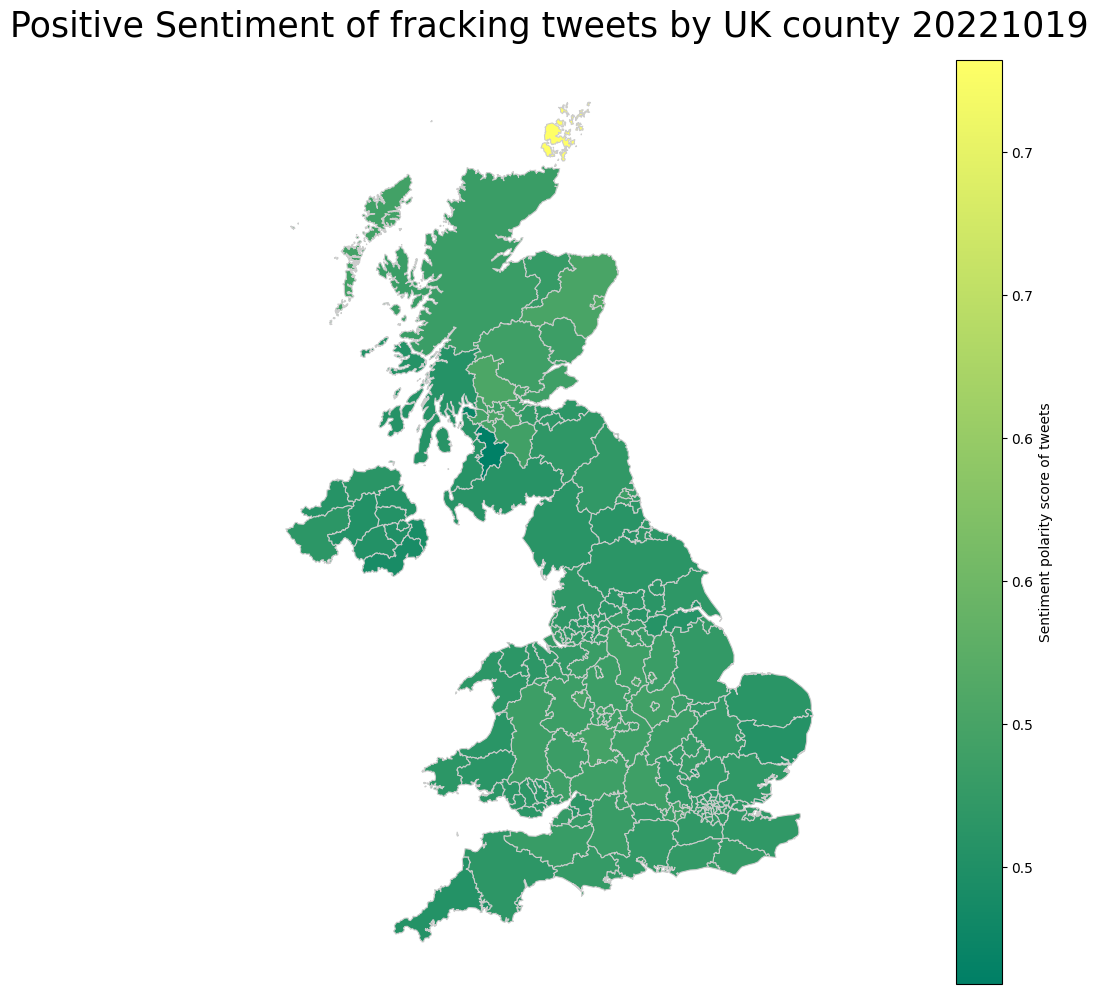

In [78]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'compound'
# set the range for the choropleth
vmin, vmax = mergedsent_uk_pos['compound'].min(numeric_only=True), mergedsent_uk_pos['compound'].max(numeric_only=True)
#vmin, vmax = mergedsent_uk['compound'].min(numeric_only=True), mergedsent_uk['compound'].max(numeric_only=True)
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

mergedsent_uk_pos.plot(column=variable, cmap='summer', linewidth=0.8, ax=ax, vmin=vmin, vmax=vmax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
title = 'Positive Sentiment of fracking tweets by UK county ' + date
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
#ax.annotate('Source: London Datastore, 2021',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='summer', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Sentiment polarity score of tweets', format='%0.1f', ax=ax)
#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_sentiment_uk_english_' + date + '.png'
#fig.savefig(fig_name, dpi=300)

### Plot tweets using London borough shapefile

In [79]:
london = "/Users/mds228/social_sensing/mapping/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_london = gpd.read_file(london)
map_london.head()

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F       NaN   
1               Croydon  E09000008   8649.441       0.000         F       NaN   
2               Bromley  E09000006  15013.487       0.000         F       NaN   
3              Hounslow  E09000018   5658.541      60.755         F       NaN   
4                Ealing  E09000009   5554.428       0.000         F       NaN   

   SUB_2006                                           geometry  
0       NaN  POLYGON ((516401.600 160201.800, 516407.300 16...  
1       NaN  POLYGON ((535009.200 159504.700, 535005.500 15...  
2       NaN  POLYGON ((540373.600 157530.400, 540361.200 15...  
3       NaN  POLYGON ((521975.800 178100.000, 521967.700 17...  
4       NaN  POLYGON ((510253.500 182881.600, 510249.900 18...

In [80]:
gdf_london = gdf.to_crs(epsg=27700)
tweets_london = gpd.sjoin(gdf_london, map_london, how="inner", predicate='intersects')
tweets_london.head()

/var/folders/sv/cwyt9nq1123g9h8k8t5gtdg00000gp/T/ipykernel_95289/3768583709.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...

  tweets_london = gpd.sjoin(gdf_london, map_london, how="inner", predicate='intersects')


source_id   source    hazard source_date    source_timestamp  \
6303  1553925072637001729  twitter  fracking    20220801 2022-08-01 02:06:22   
6299  1554004106385186817  twitter  fracking    20220801 2022-08-01 07:20:25   
6298  1554010934556999680  twitter  fracking    20220801 2022-08-01 07:47:33   
6295  1554023573781729280  twitter  fracking    20220801 2022-08-01 08:37:47   
6290  1554065410135302145  twitter  fracking    20220801 2022-08-01 11:24:01   

                                            source_text  \
6303  Petition: End the ban on fracking https://t.co...   
6299  @amgarratt Likewise! Ditto a fracking site (pr...   
6298  Lovelock saw Britain's vast shale gas reserves...   
6295  .@CitySamuel rightly highlights that nuclear &...   
6290  @dmarusic @AasaRaiko Fracking is terrible. We ...   

                                            source_json  \
6303  {"lang": "en", "edit_history_tweet_ids": ["155...   
6299  {"public_metrics": {"retweet_count": 0, "reply...   
6298  {"public_metrics": {"retweet_count": 60, "repl...   
6295  {"text": ".@CitySamuel rightly highlights that...   
6290  {"text": "@dmarusic @AasaRaiko Fracking is ter...   

                                            source_html  \
6303  <blockquote class='missing'>This tweet is no l...   
6299  <blockquote class='missing'>This tweet is no l...   
6298  <blockquote class='missing'>This tweet is no l...   
6295  <blockquote class='missing'>This tweet is no l...   
6290  <blockquote class='missing'>This tweet is no l...   

                                               location  warning  ...    pos  \
6303  POLYGON ((0.2977764737227441 51.47218218491557...        0  ...  0.000   
6299  POLYGON ((0.2977764737227441 51.47218218491557...        0  ...  0.000   
6298  POLYGON ((0.2977764737227441 51.47218218491557...        0  ...  0.196   
6295  MULTIPOLYGON (((0.0172329446360064 53.52602506...        0  ...  0.049   
6290  MULTIPOLYGON (((0.618817560217254 51.519843943...        0  ...  0.000   

                                               geometry  index_right    NAME  \
6303  POLYGON ((559683.797 177305.395, 558582.002 17...           18  Sutton   
6299  POLYGON ((559683.797 177305.395, 558582.002 17...           18  Sutton   
6298  POLYGON ((559683.797 177305.395, 558582.002 17...           18  Sutton   
6295  MULTIPOLYGON (((533819.503 405155.105, 536357....           18  Sutton   
6290  MULTIPOLYGON (((581788.097 183353.604, 583009....           18  Sutton   

       GSS_CODE  HECTARES NONLD_AREA  ONS_INNER SUB_2009 SUB_2006  
6303  E09000029  4384.698        0.0          F      NaN      NaN  
6299  E09000029  4384.698        0.0          F      NaN      NaN  
6298  E09000029  4384.698        0.0          F      NaN      NaN  
6295  E09000029  4384.698        0.0          F      NaN      NaN  
6290  E09000029  4384.698        0.0          F      NaN      NaN  

[5 rows x 25 columns]

In [81]:
tweets_london = tweets_london.groupby( [ "NAME"] ).size().to_frame(name = 'count').reset_index()
tweets_london.head()

NAME  count
0  Barking and Dagenham  11637
1                Barnet  11566
2                Bexley  12617
3                 Brent  11320
4               Bromley  13517

In [82]:
# joining the geodataframe with the cleaned up csv dataframe
merged_london = map_london.set_index('NAME').join(tweets_london.set_index('NAME'))
#.head() returns the top 5(by default ) lines of the dataframe
merged_london.head()

GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  SUB_2009  \
NAME                                                                         
Kingston upon Thames  E09000021   3726.117       0.000         F       NaN   
Croydon               E09000008   8649.441       0.000         F       NaN   
Bromley               E09000006  15013.487       0.000         F       NaN   
Hounslow              E09000018   5658.541      60.755         F       NaN   
Ealing                E09000009   5554.428       0.000         F       NaN   

                      SUB_2006  \
NAME                             
Kingston upon Thames       NaN   
Croydon                    NaN   
Bromley                    NaN   
Hounslow                   NaN   
Ealing                     NaN   

                                                               geometry  count  
NAME                                                                            
Kingston upon Thames  POLYGON ((516401.600 160201.800, 516407.300 16...  12819  
Croydon               POLYGON ((535009.200 159504.700, 535005.500 15...  12903  
Bromley               POLYGON ((540373.600 157530.400, 540361.200 15...  13517  
Hounslow              POLYGON ((521975.800 178100.000, 521967.700 17...  12710  
Ealing                POLYGON ((510253.500 182881.600, 510249.900 18...  11144

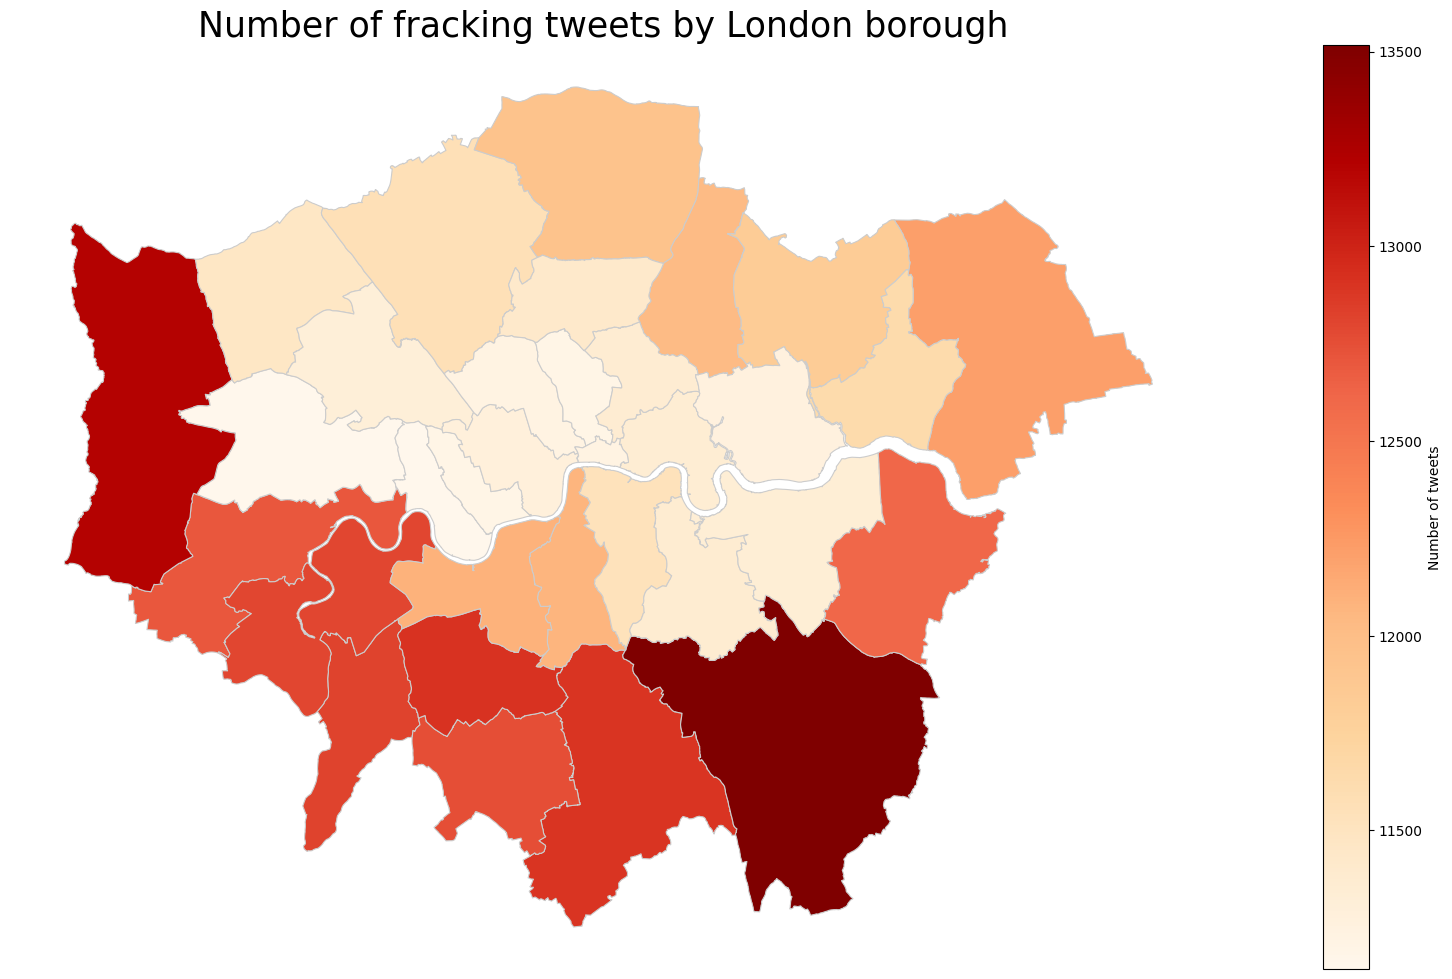

In [83]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'count'
# set the range for the choropleth
#vmin, vmax = merged_london['count'].min(), merged_london['count'].max()
vmin, vmax = merged_london['count'].min(), merged_london['count'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30,12))

merged_london.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
title = 'Number of fracking tweets by London borough '
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
#ax.annotate('using geolocated tweets containing heatwave related keywords in english, dutch and greek',xy=(0, 0), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, label=r'Number of tweets', format='%1.0f', ax=ax)
#saving our map as .png file.
#fig_name = '/Users/mds228/social_sensing/fracking_tweets/frackingtweets_london_english.png'
#fig.savefig(fig_name, dpi=300)

In [84]:
#Things to think about:
    # - How to normalise for tweet activity in a location for population/propensity for tweets from that location 